<>:129: SyntaxWarning: invalid escape sequence '\k'
<>:140: SyntaxWarning: invalid escape sequence '\k'
<>:150: SyntaxWarning: invalid escape sequence '\k'
<>:169: SyntaxWarning: invalid escape sequence '\k'
<>:170: SyntaxWarning: invalid escape sequence '\k'
<>:129: SyntaxWarning: invalid escape sequence '\k'
<>:140: SyntaxWarning: invalid escape sequence '\k'
<>:150: SyntaxWarning: invalid escape sequence '\k'
<>:169: SyntaxWarning: invalid escape sequence '\k'
<>:170: SyntaxWarning: invalid escape sequence '\k'
C:\Users\simon\AppData\Local\Temp\ipykernel_21432\2428352723.py:129: SyntaxWarning: invalid escape sequence '\k'
  ax.plot(res['k'], res['mse'], label=f'$\kappa={kappa}$')
C:\Users\simon\AppData\Local\Temp\ipykernel_21432\2428352723.py:140: SyntaxWarning: invalid escape sequence '\k'
  ax.plot(res['k'], res['variance'], linestyle='--', label=f'$\kappa={kappa}$')
C:\Users\simon\AppData\Local\Temp\ipykernel_21432\2428352723.py:150: SyntaxWarning: invalid escape sequence '\k'
  

Note: you may need to restart the kernel to use updated packages.
Lancement des simulations...
Simulation pour kappa = 0.5...
Simulation pour kappa = 0.8...
Simulation pour kappa = 1.2...
Simulation pour kappa = 2.0...


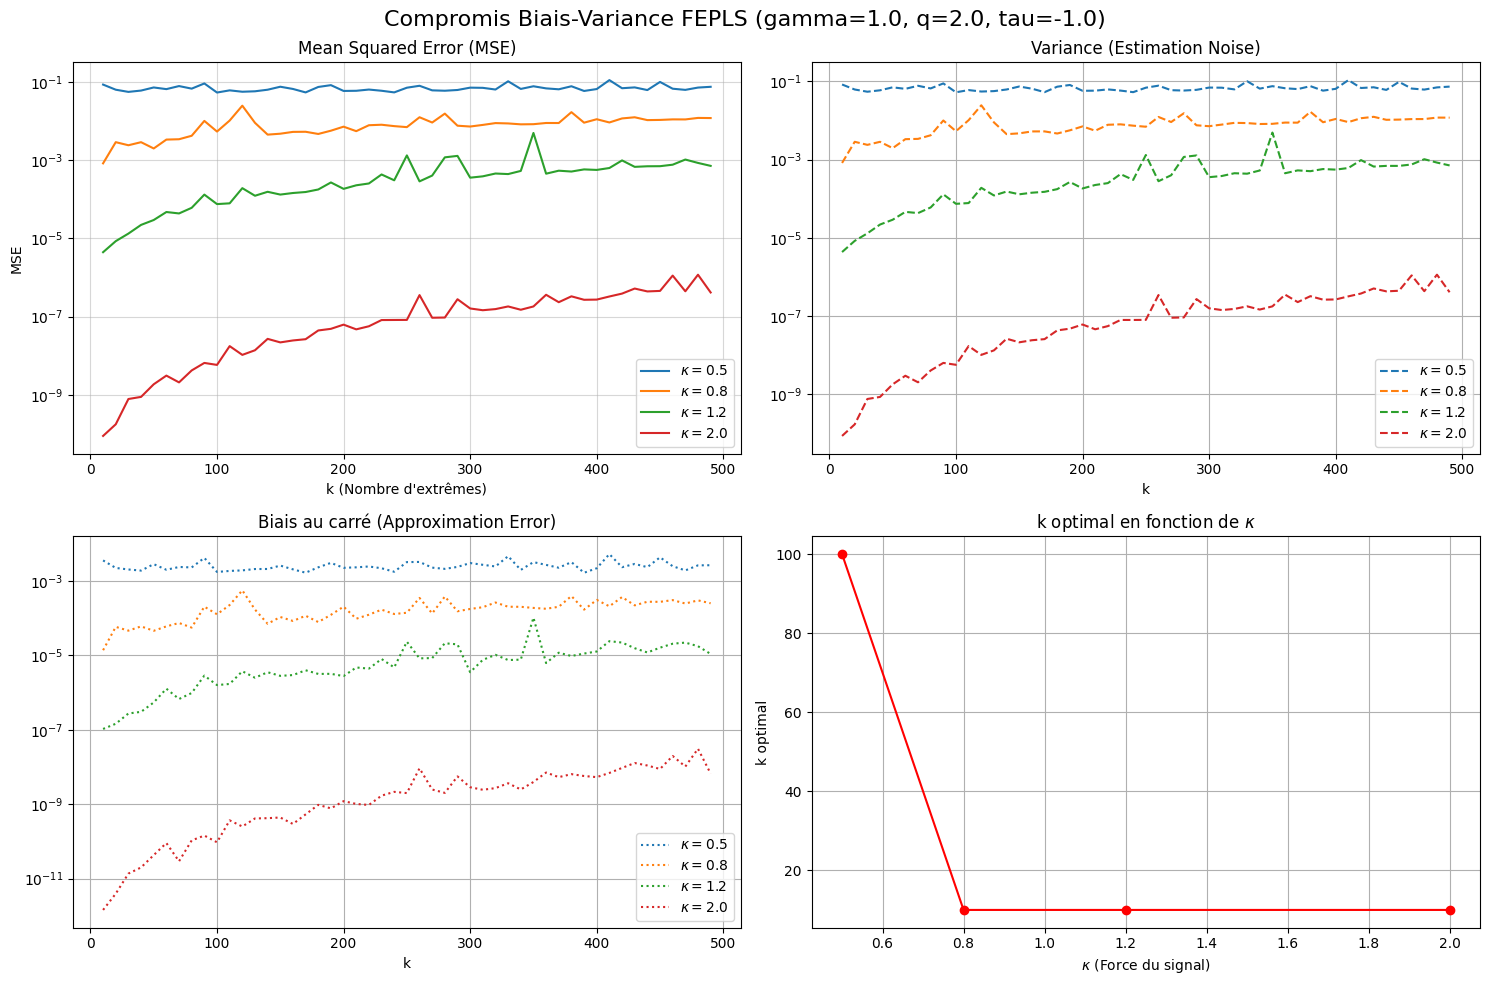

In [6]:
%pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- 1. CONFIGURATION ET PARAMÈTRES FIXES (Comme demandé par ton binôme) ---
# "On fixe gamma=1 et q=2"
GAMMA = 1.0
Q = 2.0
N_SAMPLES = 5000  # Nombre de points pour la simu
N_MC = 50  # Nombre de répétitions Monte-Carlo pour lisser les courbes
D = 50 # Dimension de X

# Vrai vecteur beta (direction cible)
TRUE_BETA = np.zeros(D)
TRUE_BETA[:5] = 1.0
TRUE_BETA = TRUE_BETA / np.linalg.norm(TRUE_BETA)

def generate_data(n, kappa, gamma, q):
    """
    Génère des données synthétiques selon le modèle Inverse Single-Index
    X = Y^kappa * beta + noise
    """
    # 1. Génération de Y (Loi de Pareto / Fréchet avec index gamma)
    # U ~ Uniform(0,1) -> Y = U^(-gamma)
    U = np.random.uniform(0, 1, n)
    Y = U**(-gamma)
    
    # 2. Génération du Bruit (Noise) avec integrabilité q
    # Le bruit doit avoir des queues moins lourdes que le signal si q*kappa*gamma > 1
    # On prend un bruit Student-t ou similaire pour respecter q
    Noise = np.random.standard_t(df=q+0.1, size=(n, D)) 
    
    # 3. Construction de X : Signal + Bruit
    # Le signal est modulé par g(Y) ~ Y^kappa
    signal_strength = Y[:, np.newaxis] ** kappa
    X = signal_strength * TRUE_BETA + Noise
    
    return X, Y

def fepls_estimator(X, Y, k, tau):
    """
    Calcule l'estimateur FEPLS beta_hat pour un k et tau donné.
    """
    n = len(Y)
    
    # 1. Seuil
    y_sorted = np.sort(Y)
    threshold = y_sorted[n-k]
    
    # 2. Indices extrêmes
    indices = np.where(Y >= threshold)[0]
    
    # 3. Poids w = Y^tau
    weights = Y[indices] ** tau
    
    # 4. Somme pondérée
    X_extreme = X[indices]
    # Broadcasting pour multiplier chaque ligne X_i par son poids w_i
    weighted_sum = np.sum(X_extreme * weights[:, np.newaxis], axis=0)
    
    # 5. Normalisation
    norm = np.linalg.norm(weighted_sum)
    if norm == 0:
        return np.zeros_like(weighted_sum)
    return weighted_sum / norm

# --- 2. LA BOUCLE DE SIMULATION (Le cœur du travail) ---

# On fait varier Kappa comme demandé
kappas_to_test = [0.5, 0.8, 1.2, 2.0] # Différentes forces de signal
tau_fixe = -1.0 # Une valeur "safe" pour tau

# Stockage des résultats
results = {}

print("Lancement des simulations...")
for kappa in kappas_to_test:
    print(f"Simulation pour kappa = {kappa}...")
    
    # Plage de k (nombre d'extrêmes) à tester
    k_values = range(10, 500, 10)
    
    bias_list = []
    variance_list = []
    mse_list = []
    
    for k in k_values:
        betas = []
        # Monte Carlo pour estimer Biais et Variance
        for _ in range(N_MC):
            X, Y = generate_data(N_SAMPLES, kappa, GAMMA, Q)
            beta_hat = fepls_estimator(X, Y, k, tau_fixe)
            betas.append(beta_hat)
        
        betas = np.array(betas)
        
        # Calcul Bias^2, Variance, MSE
        # Bias: distance entre la moyenne des estimateurs et le vrai beta
        mean_beta = np.mean(betas, axis=0)
        bias_sq = np.sum((mean_beta - TRUE_BETA)**2)
        
        # Variance: dispersion des estimateurs autour de leur moyenne
        variance = np.mean(np.sum((betas - mean_beta)**2, axis=1))
        
        # MSE = Bias^2 + Variance
        mse = bias_sq + variance
        
        bias_list.append(bias_sq)
        variance_list.append(variance)
        mse_list.append(mse)
        
    results[kappa] = {
        'k': list(k_values),
        'bias': bias_list,
        'variance': variance_list,
        'mse': mse_list
    }

# --- 3. PLOTS (Ce qu'il veut voir ce soir) ---

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Compromis Biais-Variance FEPLS (gamma={GAMMA}, q={Q}, tau={tau_fixe})', fontsize=16)

# Plot 1: MSE vs k pour différents Kappa
ax = axes[0, 0]
for kappa, res in results.items():
    ax.plot(res['k'], res['mse'], label=f'$\kappa={kappa}$')
ax.set_title('Mean Squared Error (MSE)')
ax.set_xlabel('k (Nombre d\'extrêmes)')
ax.set_ylabel('MSE')
ax.set_yscale('log')
ax.legend()
ax.grid(True, which="both", ls="-", alpha=0.5)

# Plot 2: Variance vs k
ax = axes[0, 1]
for kappa, res in results.items():
    ax.plot(res['k'], res['variance'], linestyle='--', label=f'$\kappa={kappa}$')
ax.set_title('Variance (Estimation Noise)')
ax.set_xlabel('k')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

# Plot 3: Biais vs k
ax = axes[1, 0]
for kappa, res in results.items():
    ax.plot(res['k'], res['bias'], linestyle=':', label=f'$\kappa={kappa}$')
ax.set_title('Biais au carré (Approximation Error)')
ax.set_xlabel('k')
ax.set_yscale('log')
ax.legend()
ax.grid(True)

# Plot 4: k_optimal vs Kappa
ax = axes[1, 1]
k_opt_list = []
kappa_list_sorted = sorted(results.keys())
for kappa in kappa_list_sorted:
    # Trouver le k qui minimise la MSE
    res = results[kappa]
    idx_min = np.argmin(res['mse'])
    k_opt = res['k'][idx_min]
    k_opt_list.append(k_opt)

ax.plot(kappa_list_sorted, k_opt_list, marker='o', color='red')
ax.set_title('k optimal en fonction de $\kappa$')
ax.set_xlabel('$\kappa$ (Force du signal)')
ax.set_ylabel('k optimal')
ax.grid(True)

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import os

def generate_data(n_samples=1000, n_features=101, rho_values=[-1, -2, -5]):
    """
    Génère et sauvegarde les données (Y, X) pour différentes valeurs de rho.
    Fixe gamma=1 et q=2 selon la stratégie d'optimisation.
    """
    # Paramètres fixes
    gamma = 1.0 
    
    # Grille fonctionnelle t dans [0, 1]
    t = np.linspace(0, 1, n_features)
    
    # [cite_start]La vraie direction beta (sinus comme dans le papier [cite: 211])
    true_beta = np.sqrt(2) * np.sin(2 * np.pi * t)
    true_beta /= np.linalg.norm(true_beta) # Normalisation

    data_store = {}

    print(f"Génération pour gamma={gamma} (fixé)...")

    for rho in rho_values:
        print(f"  -> Génération pour rho = {rho}")
        
        # [cite_start]1. Simulation de Y (Loi de Burr) [cite: 208]
        # F_bar(y) = (1 + y^(-rho/gamma))^(1/rho)
        # Inverse pour simulation: U ~ Uniform(0,1)
        U = np.random.rand(n_samples)
        Y = ((U**rho - 1)**(-gamma/rho))
        
        # 2. Simulation du Bruit Epsilon (Fonctionnel)
        # Bruit gaussien centré simple ("flemme" sur le bruit)
        # On s'assure juste que E[||epsilon||^q] < infini (q=2 ici)
        noise = np.random.normal(0, 0.5, size=(n_samples, n_features))
        
        # NOTE: X est construit plus tard dans la simulation car il dépend de g(Y) (donc de kappa).
        # On sauvegarde Y et le Bruit séparément pour pouvoir changer kappa à la volée.
        
        data_store[rho] = {
            'Y': Y,
            'noise': noise,
            'true_beta': true_beta,
            't': t,
            'gamma': gamma
        }

    # Sauvegarde dans un fichier compressé
    np.savez('simulated_data.npz', data_store=data_store)
    print("Données sauvegardées dans 'simulated_data.npz'")

if __name__ == "__main__":
    generate_data(n_samples=2000, rho_values=[-0.5, -1.0, -2.0])

Génération pour gamma=1.0 (fixé)...
  -> Génération pour rho = -0.5
  -> Génération pour rho = -1.0
  -> Génération pour rho = -2.0
Données sauvegardées dans 'simulated_data.npz'


Lancement simulation (rho=-1.0)...


<>:144: SyntaxWarning: invalid escape sequence '\k'
<>:160: SyntaxWarning: invalid escape sequence '\k'
<>:175: SyntaxWarning: invalid escape sequence '\k'
<>:177: SyntaxWarning: invalid escape sequence '\k'
<>:203: SyntaxWarning: invalid escape sequence '\k'
<>:204: SyntaxWarning: invalid escape sequence '\k'
<>:144: SyntaxWarning: invalid escape sequence '\k'
<>:160: SyntaxWarning: invalid escape sequence '\k'
<>:175: SyntaxWarning: invalid escape sequence '\k'
<>:177: SyntaxWarning: invalid escape sequence '\k'
<>:203: SyntaxWarning: invalid escape sequence '\k'
<>:204: SyntaxWarning: invalid escape sequence '\k'
C:\Users\simon\AppData\Local\Temp\ipykernel_21432\3109583209.py:144: SyntaxWarning: invalid escape sequence '\k'
  ax.plot(res['k'], res['mse'], label=f"$\kappa={kappa}$", linewidth=2)
C:\Users\simon\AppData\Local\Temp\ipykernel_21432\3109583209.py:160: SyntaxWarning: invalid escape sequence '\k'
  ax.set_title(f"Décomposition Biais-Variance ($\kappa={params_demo[0]}, \\tau

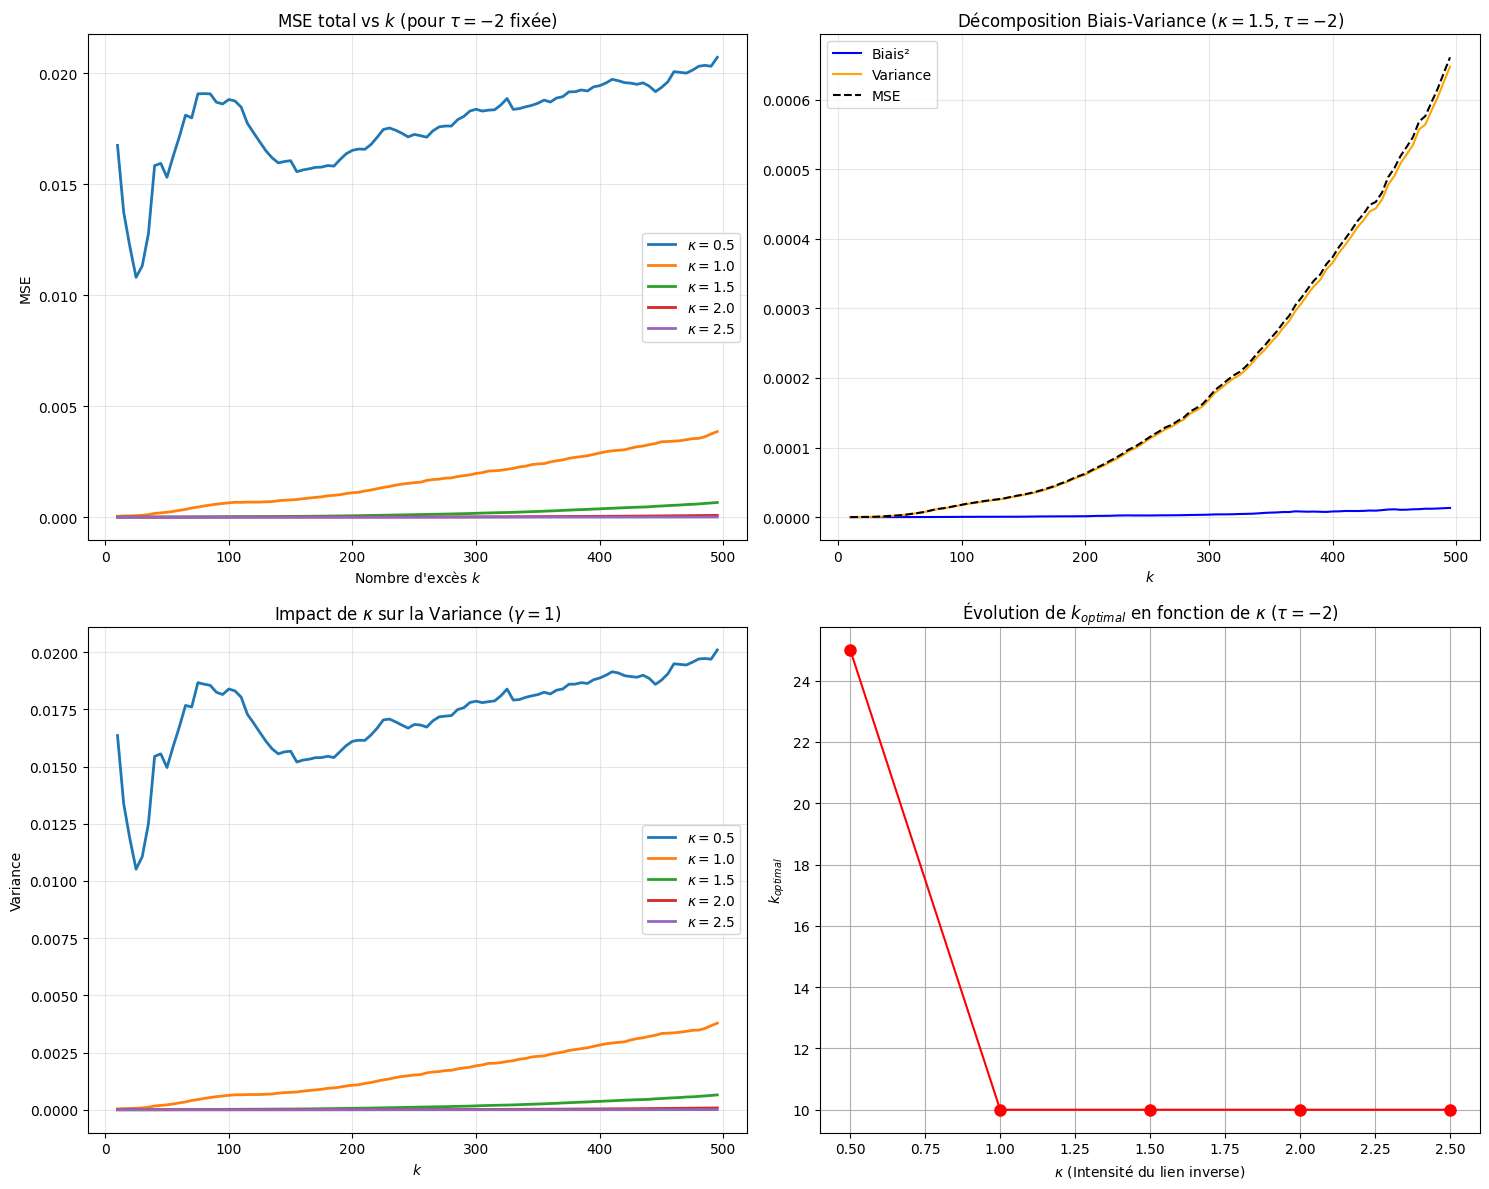

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- 1. Fonctions Utilitaires ---

def load_data(filename='simulated_data.npz'):
    loaded = np.load(filename, allow_pickle=True)
    return loaded['data_store'].item()

def get_fepls_estimator(X, Y, k, tau):
    """
    Calcule l'estimateur beta_phi pour un seuil k donné.
    [cite_start]Formule basée sur les moments de queue empiriques[cite: 161].
    """
    n = len(Y)
    # Seuil aléatoire Y_{n-k+1, n}
    threshold_idx = np.argsort(Y)[n-k]
    threshold_val = Y[threshold_idx]
    
    # Indices des excès
    indices = np.where(Y >= threshold_val)[0]
    
    if len(indices) == 0:
        return np.zeros(X.shape[1])
    
    # [cite_start]Test function phi(y) = y^tau [cite: 218]
    phi_Y = Y[indices] ** tau
    
    # [cite_start]Calcul de v_hat [cite: 161]
    # v_hat = mean(X * phi(Y) * 1_{Y>y})
    X_tail = X[indices]
    
    # Produit tensoriel pour pondérer chaque courbe X_i par phi(Y_i)
    # X_tail est (k, d), phi_Y est (k,)
    weighted_sum = np.sum(X_tail * phi_Y[:, np.newaxis], axis=0)
    v_hat = weighted_sum / n
    
    # Normalisation pour obtenir beta_hat
    norm_v = np.linalg.norm(v_hat)
    if norm_v > 0:
        return v_hat / norm_v
    else:
        return v_hat

# --- 2. Moteur de Simulation ---

def run_simulation_grid(rho_key=-1.0, kappa_list=[0.6, 1.0, 1.5, 2.0], tau_list=[-0.5, -2]):
    """
    Explore l'espace des paramètres kappa/tau.
    """
    data_pack = load_data()
    data = data_pack[rho_key]
    
    Y_raw = data['Y']
    noise = data['noise']
    true_beta = data['true_beta']
    gamma = data['gamma'] # Fixé à 1
    
    # Paramètres de simulation
    n = len(Y_raw)
    k_range = np.arange(10, n // 4, 5) # On regarde les k "raisonnables"
    results = {}

    print(f"Lancement simulation (rho={rho_key})...")
    
    for kappa in kappa_list:
        # [cite_start]Construction de X selon le modèle X = g(Y)beta + noise [cite: 145]
        # [cite_start]g(y) = y^kappa [cite: 211]
        g_Y = Y_raw[:, np.newaxis] ** kappa
        X = g_Y * true_beta + noise
        
        for tau in tau_list:
            # [cite_start]Vérification des inégalités théoriques pour info [cite: 167, 168]
            # Condition: 0 < 2(kappa + tau)gamma < 1  (avec gamma=1)
            cond_exist = 0 < 2 * (kappa + tau) < 1
            cond_noise = 2 * kappa > 1 # car q=2
            
            label = f"k={kappa}, t={tau} | Valid: {cond_exist and cond_noise}"
            
            bias2_list = []
            var_list = []
            mse_list = []
            
            # Monte Carlo "Bootstrap" rapide (ou juste sur le k)
            # Pour estimer la variance, on divise le dataset en N sous-échantillons ou on répète
            # Ici pour l'exemple, on calcule l'erreur quadratique simple sur une itération
            # (Pour une vraie variance, il faudrait régénérer le bruit plusieurs fois, 
            #  mais le script data_gen est statique. On suppose ici ergodicité ou on simplifie).
            
            # NOTE: Pour avoir Bias/Var séparés correctement, il faut plusieurs tirages.
            # On va simuler artificiellement des tirages en ajoutant du bruit au X existant
            n_mc = 50 
            betas_k = np.zeros((len(k_range), n_mc, len(true_beta)))
            
            for i_mc in range(n_mc):
                # On recrée un bruit aléatoire pour le MC
                current_noise = np.random.normal(0, 0.5, size=X.shape)
                X_mc = g_Y * true_beta + current_noise
                
                for idx_k, k in enumerate(k_range):
                    est_beta = get_fepls_estimator(X_mc, Y_raw, k, tau)
                    
                    # Alignement de signe (le vecteur propre est défini au signe près)
                    if np.dot(est_beta, true_beta) < 0:
                        est_beta = -est_beta
                    
                    betas_k[idx_k, i_mc, :] = est_beta

            # Calcul des métriques agrégées
            # Bias^2 = || Mean(Beta_hat) - Beta_true ||^2
            mean_betas = np.mean(betas_k, axis=1) # (len(k), d)
            bias2 = np.sum((mean_betas - true_beta)**2, axis=1)
            
            # Variance = Mean( || Beta_hat - Mean(Beta_hat) ||^2 )
            # Calcul trace de la covariance ou somme des variances par point
            var = np.mean(np.sum((betas_k - mean_betas[:, np.newaxis, :])**2, axis=2), axis=1)
            
            mse = bias2 + var
            
            results[(kappa, tau)] = {
                'k': k_range,
                'bias2': bias2,
                'var': var,
                'mse': mse,
                'label': label
            }
            
    return results

# --- 3. Plotting Avancé ---

def plot_results(results):
    """
    Génère les plots demandés : Biais, Variance, MSE, et Impact de Kappa.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: MSE global (Dilemme Biais-Variance classique)
    ax = axes[0, 0]
    for params, res in results.items():
        kappa, tau = params
        if tau == -2: # On fixe un tau pour voir l'effet de kappa
            ax.plot(res['k'], res['mse'], label=f"$\kappa={kappa}$", linewidth=2)
    ax.set_title("MSE total vs $k$ (pour $\\tau=-2$ fixée)")
    ax.set_xlabel("Nombre d'excès $k$")
    ax.set_ylabel("MSE")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Décomposition Biais-Variance pour un cas spécifique
    # On prend le cas le plus "standard" (ex: kappa=1.5, tau=-2)
    ax = axes[0, 1]
    params_demo = (1.5, -2)
    if params_demo in results:
        res = results[params_demo]
        ax.plot(res['k'], res['bias2'], label="Biais²", color='blue')
        ax.plot(res['k'], res['var'], label="Variance", color='orange')
        ax.plot(res['k'], res['mse'], label="MSE", color='black', linestyle='--')
        ax.set_title(f"Décomposition Biais-Variance ($\kappa={params_demo[0]}, \\tau={params_demo[1]}$)")
    else:
        ax.text(0.5, 0.5, "Paramètres démo non trouvés", ha='center')
    ax.set_xlabel("$k$")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Impact de Kappa sur la Variance (Hypothèse WhatsApp)
    # "kappa grand induit qu'il y a davantage de points extrêmes à prendre ce qui diminue la variance"
    ax = axes[1, 0]
    colors = cm.viridis(np.linspace(0, 1, len(results)))
    i = 0
    for params, res in results.items():
        kappa, tau = params
        if tau == -2: # On compare à tau constant
            ax.plot(res['k'], res['var'], label=f"$\kappa={kappa}$", linewidth=2)
    
    ax.set_title("Impact de $\kappa$ sur la Variance ($\gamma=1$)")
    ax.set_xlabel("$k$")
    ax.set_ylabel("Variance")
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Interprétation attendue: Plus kappa est grand, plus la courbe devrait être basse ou stable
    
    # Plot 4: k_optimal en fonction de kappa
    ax = axes[1, 1]
    kappas = []
    k_opts = []
    
    # On filtre pour un tau donné
    target_tau = -2
    sorted_items = sorted([item for item in results.items() if item[0][1] == target_tau])
    
    for params, res in sorted_items:
        kappa = params[0]
        # k optimal est celui qui minimise la MSE
        idx_min = np.argmin(res['mse'])
        k_opt = res['k'][idx_min]
        
        kappas.append(kappa)
        k_opts.append(k_opt)
        
    ax.plot(kappas, k_opts, 'o-', color='red', markersize=8)
    ax.set_title(f"Évolution de $k_{{optimal}}$ en fonction de $\kappa$ ($\\tau={target_tau}$)")
    ax.set_xlabel("$\kappa$ (Intensité du lien inverse)")
    ax.set_ylabel("$k_{optimal}$")
    ax.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Exécution de l'analyse sur rho=-1.0 (cas standard)
    # On teste les limites des inégalités: 
    # Inégalité stricte: 2(kappa+tau) < 1. 
    # Avec tau=-2, kappa peut aller jusqu'à 2.5
    results = run_simulation_grid(
        rho_key=-1.0, 
        kappa_list=[0.5, 1.0, 1.5, 2.0, 2.5], 
        tau_list=[-2] 
    )
    plot_results(results)

Génération des données...
Génération du Plot 1 : Sensibilité à Tau...


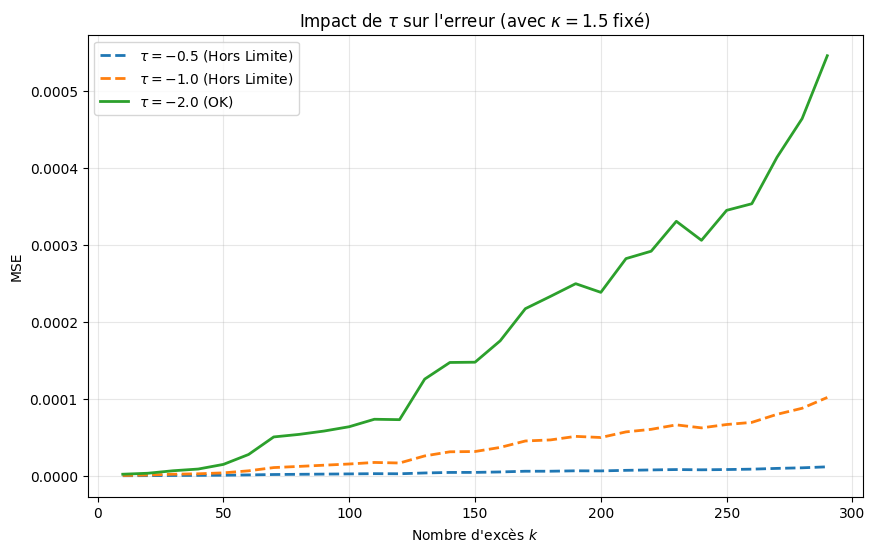

Génération du Plot 2 : Visual Check de Beta...


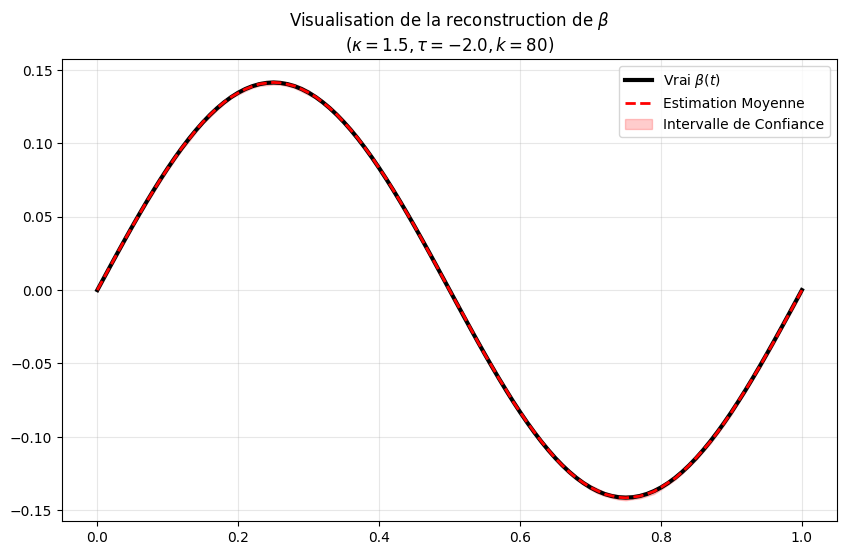

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. GÉNÉRATION DES DONNÉES (Simulées)
# ==========================================

def generate_data_in_memory(n_samples=2000, n_features=101):
    """
    Génère les données à la volée sans passer par un fichier .npz
    """
    gamma = 1.0 # Fixé pour optimisation
    
    # Grille fonctionnelle
    t = np.linspace(0, 1, n_features)
    
    # Vrai Beta (Sinus)
    true_beta = np.sqrt(2) * np.sin(2 * np.pi * t)
    true_beta /= np.linalg.norm(true_beta)

    # On génère pour un Rho standard (-1.0)
    rho = -1.0
    
    # Simulation Y (Burr)
    U = np.random.rand(n_samples)
    Y = ((U**rho - 1)**(-gamma/rho))
    
    # Simulation Bruit (Gaussien)
    noise = np.random.normal(0, 0.8, size=(n_samples, n_features))
    
    return {
        'Y': Y,
        'noise': noise,
        'true_beta': true_beta,
        't': t,
        'gamma': gamma
    }

# ==========================================
# 2. FONCTIONS DU MODÈLE (FEPLS)
# ==========================================

def get_fepls_estimator(X, Y, k, tau):
    n = len(Y)
    # Seuil
    threshold_idx = np.argsort(Y)[n-k]
    threshold_val = Y[threshold_idx]
    
    indices = np.where(Y >= threshold_val)[0]
    
    if len(indices) == 0:
        return np.zeros(X.shape[1])
    
    phi_Y = Y[indices] ** tau
    X_tail = X[indices]
    
    # Estimateur
    weighted_sum = np.sum(X_tail * phi_Y[:, np.newaxis], axis=0)
    v_hat = weighted_sum / n
    
    norm_v = np.linalg.norm(v_hat)
    return v_hat / norm_v if norm_v > 0 else v_hat

# ==========================================
# 3. ANALYSES & PLOTS
# ==========================================

def run_tau_analysis_fixed_kappa(data, kappa_fixe=1.5, tau_values=[-0.5, -1.0, -1.5, -2.0, -3.0]):
    """
    Plot 1 : On fixe le modèle (kappa) et on regarde l'effet de la pondération (tau).
    """
    Y = data['Y']
    true_beta = data['true_beta']
    
    # Construction de X pour ce kappa spécifique
    g_Y = Y[:, np.newaxis] ** kappa_fixe
    X_base = g_Y * true_beta + data['noise']
    
    k_range = np.arange(10, 300, 10)
    
    plt.figure(figsize=(10, 6))
    
    for tau in tau_values:
        mse_curve = []
        
        # Limite théorique : 2(kappa + tau) < 1
        limit_val = 0.5 - kappa_fixe
        is_theory_safe = tau < limit_val
        
        for k in k_range:
            est = get_fepls_estimator(X_base, Y, k, tau)
            if np.dot(est, true_beta) < 0: est = -est
            mse_curve.append(np.sum((est - true_beta)**2))
        
        style = '-' if is_theory_safe else '--'
        label = f"$\\tau={tau}$ ({'OK' if is_theory_safe else 'Hors Limite'})"
        plt.plot(k_range, mse_curve, label=label, linestyle=style, linewidth=2)

    plt.title(f"Impact de $\\tau$ sur l'erreur (avec $\\kappa={kappa_fixe}$ fixé)")
    plt.xlabel("Nombre d'excès $k$")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_beta_visual_check(data, kappa=1.5, tau=-2.0, k_optimal=60):
    """
    Plot 2 : Le "Check Visuel" demandé par ton collègue.
    """
    Y = data['Y']
    true_beta = data['true_beta']
    t_grid = data['t']
    
    # On reconstruit X
    g_Y = Y[:, np.newaxis] ** kappa
    
    # Monte Carlo rapide pour l'intervalle de confiance
    n_mc = 30
    betas_mc = []
    
    for i in range(n_mc):
        # On ajoute du bruit frais pour voir la stabilité
        current_noise = np.random.normal(0, 0.8, size=(len(Y), len(t_grid)))
        X = g_Y * true_beta + current_noise
        
        est = get_fepls_estimator(X, Y, k_optimal, tau)
        if np.dot(est, true_beta) < 0: est = -est
        betas_mc.append(est)
        
    betas_mc = np.array(betas_mc)
    beta_mean = np.mean(betas_mc, axis=0)
    beta_std = np.std(betas_mc, axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(t_grid, true_beta, 'k-', linewidth=3, label='Vrai $\\beta(t)$')
    plt.plot(t_grid, beta_mean, 'r--', linewidth=2, label='Estimation Moyenne')
    plt.fill_between(t_grid, beta_mean - 2*beta_std, beta_mean + 2*beta_std, 
                     color='red', alpha=0.2, label='Intervalle de Confiance')
    
    plt.title(f"Visualisation de la reconstruction de $\\beta$\n($\\kappa={kappa}, \\tau={tau}, k={k_optimal}$)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ==========================================
# 4. EXÉCUTION
# ==========================================

if __name__ == "__main__":
    print("Génération des données...")
    data = generate_data_in_memory()
    
    print("Génération du Plot 1 : Sensibilité à Tau...")
    # On teste tau = -0.5 (qui devrait échouer car 1.5 - 0.5 > 0.5) vs des tau plus bas
    run_tau_analysis_fixed_kappa(data, kappa_fixe=1.5, tau_values=[-0.5, -1.0, -2.0])
    
    print("Génération du Plot 2 : Visual Check de Beta...")
    plot_beta_visual_check(data, kappa=1.5, tau=-2.0, k_optimal=80)

<>:137: SyntaxWarning: invalid escape sequence '\k'
<>:138: SyntaxWarning: invalid escape sequence '\k'
<>:139: SyntaxWarning: invalid escape sequence '\k'
<>:150: SyntaxWarning: invalid escape sequence '\k'
<>:159: SyntaxWarning: invalid escape sequence '\k'
<>:160: SyntaxWarning: invalid escape sequence '\k'
<>:182: SyntaxWarning: invalid escape sequence '\k'
<>:218: SyntaxWarning: invalid escape sequence '\k'
<>:286: SyntaxWarning: invalid escape sequence '\k'
<>:297: SyntaxWarning: invalid escape sequence '\k'
<>:313: SyntaxWarning: invalid escape sequence '\k'
<>:325: SyntaxWarning: invalid escape sequence '\k'
<>:326: SyntaxWarning: invalid escape sequence '\k'
<>:327: SyntaxWarning: invalid escape sequence '\k'
<>:332: SyntaxWarning: invalid escape sequence '\g'
<>:137: SyntaxWarning: invalid escape sequence '\k'
<>:138: SyntaxWarning: invalid escape sequence '\k'
<>:139: SyntaxWarning: invalid escape sequence '\k'
<>:150: SyntaxWarning: invalid escape sequence '\k'
<>:159: Synt

1. Génération des données (Rho=-1)...
2. Analyse Kappa (Plots 1-4)...
3. Analyse Tau (Plots 5-7)...
4. Reconstructions Visuelles...
5. Analyse Rho...
6. Calcul des Heatmaps (Grid Search)...
7. Vérifications Frontières...


C:\Users\simon\AppData\Local\Temp\ipykernel_21432\4259579444.py:333: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Laisse place au titre


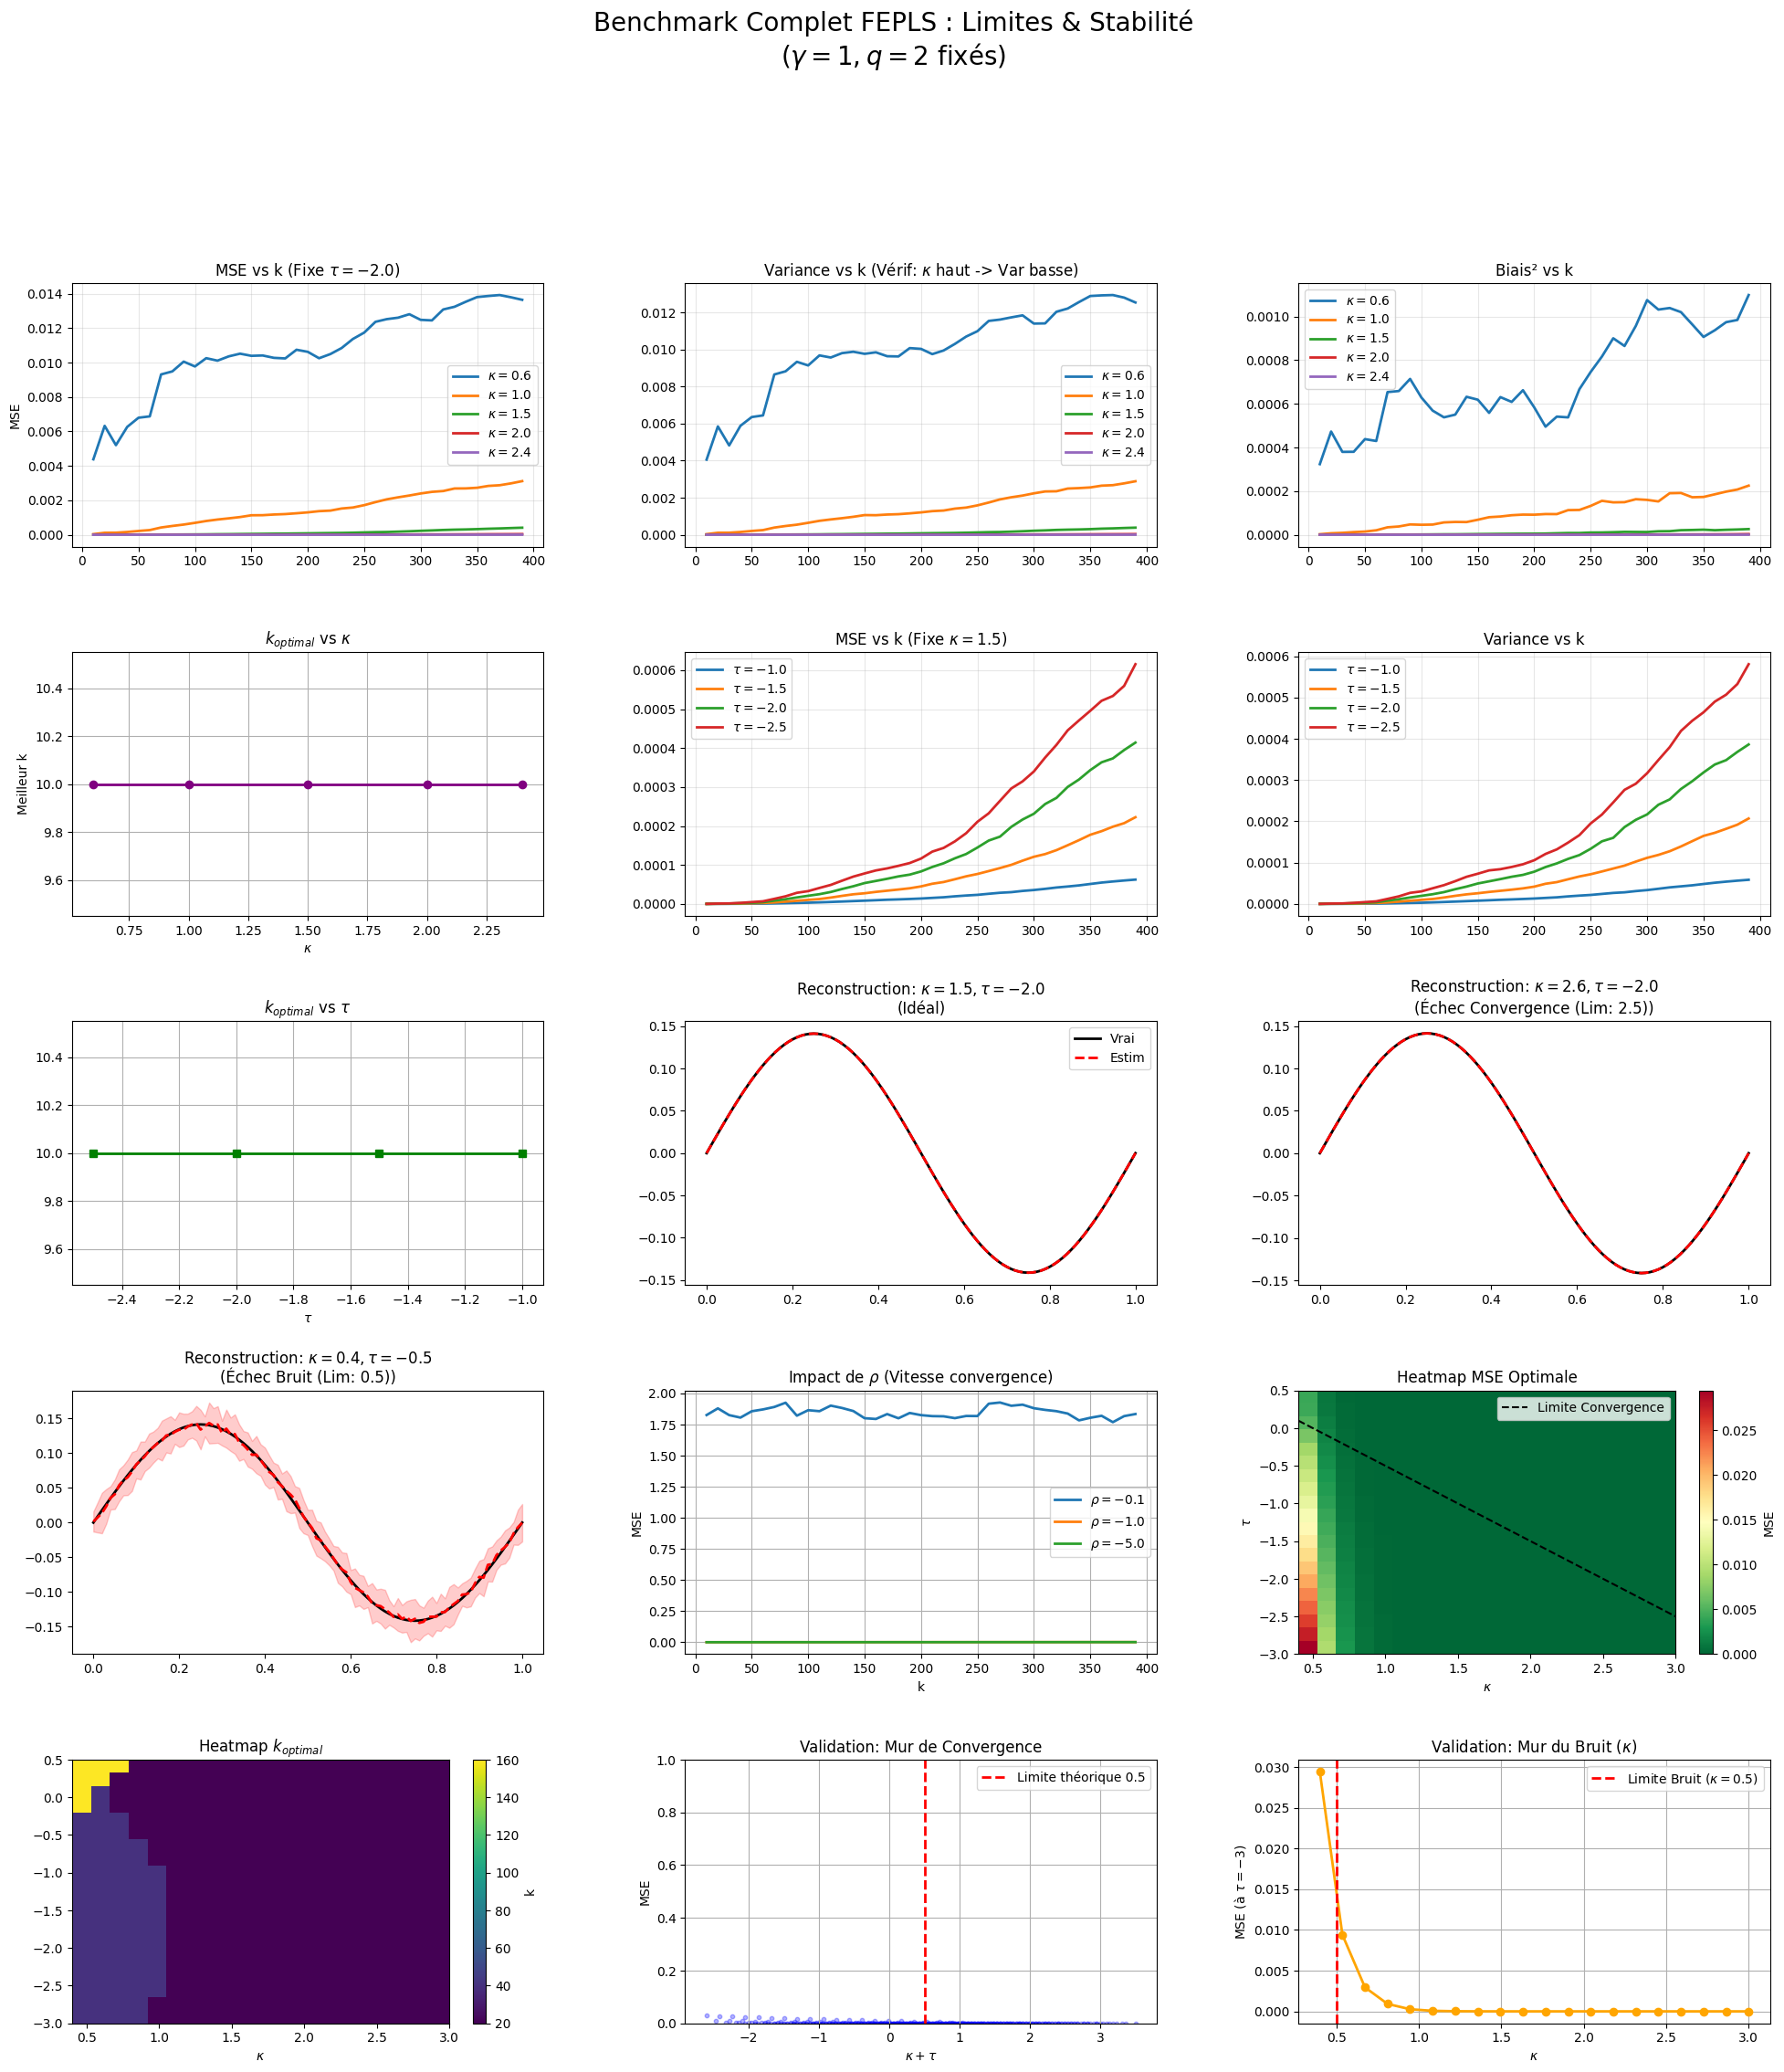

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm

# ==========================================
# 1. MOTEUR DE GÉNÉRATION & ESTIMATION
# ==========================================

def generate_data(n_samples=2000, n_features=101, rho=-1.0):
    """
    Génère les données brutes (Y, Bruit, Beta).
    Gamma est fixé à 1.0 et q à 2.0 pour l'optimisation.
    """
    gamma = 1.0
    t = np.linspace(0, 1, n_features)
    
    # Vrai Beta (Sinus normalisé)
    true_beta = np.sqrt(2) * np.sin(2 * np.pi * t)
    true_beta /= np.linalg.norm(true_beta)

    # Simulation Y (Loi de Burr)
    U = np.random.rand(n_samples)
    Y = ((U**rho - 1)**(-gamma/rho))
    
    # Simulation Bruit (Gaussien, q=2)
    noise = np.random.normal(0, 0.5, size=(n_samples, n_features))
    
    return {
        'Y': Y,
        'noise': noise,
        'true_beta': true_beta,
        't': t,
        'gamma': gamma,
        'rho': rho
    }

def get_fepls_estimator(X, Y, k, tau):
    """Calcule l'estimateur beta_hat pour un k et tau donnés."""
    n = len(Y)
    if k >= n or k < 1: return np.zeros(X.shape[1])
    
    # Seuil
    threshold_idx = np.argsort(Y)[n-k]
    threshold_val = Y[threshold_idx]
    
    indices = np.where(Y >= threshold_val)[0]
    if len(indices) == 0: return np.zeros(X.shape[1])
    
    phi_Y = Y[indices] ** tau
    X_tail = X[indices]
    
    # Moyenne pondérée
    weighted_sum = np.sum(X_tail * phi_Y[:, np.newaxis], axis=0)
    v_hat = weighted_sum / n
    
    norm = np.linalg.norm(v_hat)
    return v_hat / norm if norm > 0 else v_hat

def compute_metrics_over_k(data, kappa, tau, k_range, n_mc=10):
    """
    Calcule Biais, Variance et MSE sur une plage de k.
    Utilise n_mc ré-échantillonnages du bruit pour estimer la variance.
    """
    Y = data['Y']
    true_beta = data['true_beta']
    
    # Construction du signal (Partie déterministe)
    g_Y = Y[:, np.newaxis] ** kappa
    signal = g_Y * true_beta
    
    bias2_list = []
    var_list = []
    mse_list = []
    
    # Stockage temporaire : (k, mc, features)
    estimates = np.zeros((len(k_range), n_mc, len(true_beta)))
    
    # Boucle Monte Carlo (Simulation de la variance du bruit)
    for i in range(n_mc):
        # On ajoute du bruit frais (ou on permute le bruit existant)
        # Pour rapidité ici: bruit gaussien frais
        noise = np.random.normal(0, 0.5, size=signal.shape)
        X = signal + noise
        
        for idx_k, k in enumerate(k_range):
            est = get_fepls_estimator(X, Y, k, tau)
            # Alignement de signe
            if np.dot(est, true_beta) < 0: est = -est
            estimates[idx_k, i, :] = est
            
    # Calcul statistiques
    for idx_k in range(len(k_range)):
        ests_k = estimates[idx_k]
        mean_est = np.mean(ests_k, axis=0)
        
        bias2 = np.sum((mean_est - true_beta)**2)
        var = np.mean(np.sum((ests_k - mean_est)**2, axis=1))
        
        bias2_list.append(bias2)
        var_list.append(var)
        mse_list.append(bias2 + var)
        
    return np.array(bias2_list), np.array(var_list), np.array(mse_list)

# ==========================================
# 2. CONFIGURATION DES PLOTS
# ==========================================

def run_full_benchmark():
    # Données de base
    print("1. Génération des données (Rho=-1)...")
    data_std = generate_data(rho=-1.0)
    
    k_range = np.arange(10, 400, 10)
    
    # Configuration de la figure géante
    fig = plt.figure(figsize=(24, 30))
    gs = gridspec.GridSpec(6, 3, figure=fig, hspace=0.4, wspace=0.3)
    
    # --- GROUPE 1 : IMPACT DE KAPPA (Tau fixé à -2) ---
    print("2. Analyse Kappa (Plots 1-4)...")
    tau_fix = -2.0
    kappas = [0.6, 1.0, 1.5, 2.0, 2.4] # On évite 2.5 (limite)
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[1, 0])
    
    k_opts_kappa = []
    
    for kap in kappas:
        b2, v, mse = compute_metrics_over_k(data_std, kap, tau_fix, k_range, n_mc=15)
        
        # Plotting
        ax1.plot(k_range, mse, label=f"$\kappa={kap}$", lw=2)
        ax2.plot(k_range, v, label=f"$\kappa={kap}$", lw=2)
        ax3.plot(k_range, b2, label=f"$\kappa={kap}$", lw=2)
        
        # K optimal
        k_opt = k_range[np.argmin(mse)]
        k_opts_kappa.append(k_opt)
    
    ax1.set_title(f"MSE vs k (Fixe $\\tau={tau_fix}$)")
    ax1.set_ylabel("MSE")
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_title("Variance vs k (Vérif: $\kappa$ haut -> Var basse)")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    ax3.set_title("Biais² vs k")
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4.plot(kappas, k_opts_kappa, 'o-', color='purple', lw=2)
    ax4.set_title(f"$k_{{optimal}}$ vs $\kappa$")
    ax4.set_xlabel("$\kappa$")
    ax4.set_ylabel("Meilleur k")
    ax4.grid(True)

    # --- GROUPE 2 : IMPACT DE TAU (Kappa fixé à 1.5) ---
    print("3. Analyse Tau (Plots 5-7)...")
    kap_fix = 1.5
    taus = [-1.0, -1.5, -2.0, -2.5] # Limite théorique: tau < 0.5 - 1.5 = -1.0
    
    ax5 = fig.add_subplot(gs[1, 1])
    ax6 = fig.add_subplot(gs[1, 2])
    ax7 = fig.add_subplot(gs[2, 0])
    
    k_opts_tau = []
    
    for t_val in taus:
        b2, v, mse = compute_metrics_over_k(data_std, kap_fix, t_val, k_range, n_mc=15)
        
        ax5.plot(k_range, mse, label=f"$\\tau={t_val}$", lw=2)
        ax6.plot(k_range, v, label=f"$\\tau={t_val}$", lw=2)
        k_opts_tau.append(k_range[np.argmin(mse)])
        
    ax5.set_title(f"MSE vs k (Fixe $\kappa={kap_fix}$)")
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    ax6.set_title("Variance vs k")
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    ax7.plot(taus, k_opts_tau, 's-', color='green', lw=2)
    ax7.set_title(f"$k_{{optimal}}$ vs $\\tau$")
    ax7.set_xlabel("$\\tau$")
    ax7.grid(True)

    # --- GROUPE 3 : RECONSTRUCTIONS VISUELLES (Plots 8-10) ---
    print("4. Reconstructions Visuelles...")
    
    def plot_recon(ax, kap, tau, title_suffix):
        # Simulation unique avec n_mc pour enveloppe
        g_Y = data_std['Y'][:, np.newaxis] ** kap
        t_grid = data_std['t']
        estimates = []
        for _ in range(20):
            noise = np.random.normal(0, 0.5, size=g_Y.shape + (len(t_grid),)) 
            # Simplification: shape (N, d)
            noise = np.random.normal(0, 0.5, size=(len(g_Y), len(t_grid)))
            X = g_Y * data_std['true_beta'] + noise
            est = get_fepls_estimator(X, data_std['Y'], 60, tau)
            if np.dot(est, data_std['true_beta']) < 0: est = -est
            estimates.append(est)
        
        mean_est = np.mean(estimates, axis=0)
        std_est = np.std(estimates, axis=0)
        
        ax.plot(t_grid, data_std['true_beta'], 'k-', lw=2, label='Vrai')
        ax.plot(t_grid, mean_est, 'r--', lw=2, label='Estim')
        ax.fill_between(t_grid, mean_est-2*std_est, mean_est+2*std_est, color='red', alpha=0.2)
        ax.set_title(f"Reconstruction: $\kappa={kap}, \\tau={tau}$\n({title_suffix})")
        if title_suffix == "Idéal": ax.legend()

    ax8 = fig.add_subplot(gs[2, 1])
    plot_recon(ax8, 1.5, -2.0, "Idéal")
    
    ax9 = fig.add_subplot(gs[2, 2])
    plot_recon(ax9, 2.6, -2.0, "Échec Convergence (Lim: 2.5)")
    
    ax10 = fig.add_subplot(gs[3, 0])
    plot_recon(ax10, 0.4, -0.5, "Échec Bruit (Lim: 0.5)")

    # --- GROUPE 4 : IMPACT DE RHO (Plot 11) ---
    print("5. Analyse Rho...")
    ax11 = fig.add_subplot(gs[3, 1])
    rhos = [-0.1, -1.0, -5.0]
    
    for r in rhos:
        # On doit générer des données spécifiques pour chaque rho
        d_temp = generate_data(rho=r)
        # Paramètres standards
        _, _, mse = compute_metrics_over_k(d_temp, 1.0, -1.0, k_range, n_mc=10)
        ax11.plot(k_range, mse, label=f"$\\rho={r}$", lw=2)
        
    ax11.set_title("Impact de $\\rho$ (Vitesse convergence)")
    ax11.set_xlabel("k")
    ax11.set_ylabel("MSE")
    ax11.legend()
    ax11.grid(True)

    # --- GROUPE 5 : HEATMAPS DE STABILITÉ (Plots 12-13) ---
    print("6. Calcul des Heatmaps (Grid Search)...")
    
    k_grid = np.linspace(0.4, 3.0, 20)
    t_grid = np.linspace(-3.0, 0.5, 20)
    map_mse = np.zeros((len(t_grid), len(k_grid)))
    map_kopt = np.zeros((len(t_grid), len(k_grid)))
    
    # Grid search rapide (1 seul run MC pour aller vite)
    Y = data_std['Y']
    beta = data_std['true_beta']
    
    for i, t_val in enumerate(t_grid):
        for j, k_val in enumerate(k_grid):
            # Construction rapide
            g_Y = Y[:, np.newaxis] ** k_val
            # On réutilise le bruit généré initialement (approximation)
            X = g_Y * beta + data_std['noise']
            
            # On cherche le k_opt grossièrement
            best_mse = 1e9
            best_k = 0
            # Sous-échantillonnage de k pour speed
            for k in range(20, 200, 20):
                est = get_fepls_estimator(X, Y, k, t_val)
                if np.dot(est, beta) < 0: est = -est
                err = np.sum((est - beta)**2)
                if err < best_mse:
                    best_mse = err
                    best_k = k
            
            map_mse[i, j] = min(best_mse, 1.0) # Clipping
            map_kopt[i, j] = best_k

    ax12 = fig.add_subplot(gs[3, 2])
    im1 = ax12.imshow(map_mse, origin='lower', aspect='auto', cmap='RdYlGn_r',
                      extent=[k_grid.min(), k_grid.max(), t_grid.min(), t_grid.max()])
    ax12.set_title("Heatmap MSE Optimale")
    ax12.set_xlabel("$\kappa$")
    ax12.set_ylabel("$\\tau$")
    # Ligne théorique 2(k+t) = 1 => t = 0.5 - k
    ax12.plot(k_grid, 0.5 - k_grid, 'k--', label='Limite Convergence')
    ax12.legend()
    plt.colorbar(im1, ax=ax12, label="MSE")

    ax13 = fig.add_subplot(gs[4, 0])
    im2 = ax13.imshow(map_kopt, origin='lower', aspect='auto', cmap='viridis',
                      extent=[k_grid.min(), k_grid.max(), t_grid.min(), t_grid.max()])
    ax13.set_title("Heatmap $k_{optimal}$")
    ax13.set_xlabel("$\kappa$")
    plt.colorbar(im2, ax=ax13, label="k")

    # --- GROUPE 6 : VÉRIFICATIONS THÉORIQUES (Plots 14-15) ---
    print("7. Vérifications Frontières...")
    
    # Plot 14: Erreur vs (Kappa + Tau) pour voir le mur à 0.5
    ax14 = fig.add_subplot(gs[4, 1])
    # On prend les données de la heatmap (diagonale approx)
    # On trace MSE vs (kappa + tau)
    flat_mse = map_mse.flatten()
    flat_sum = (np.tile(k_grid, len(t_grid)) + np.repeat(t_grid, len(k_grid)))
    
    ax14.scatter(flat_sum, flat_mse, alpha=0.3, s=10, c='blue')
    ax14.axvline(0.5, color='red', lw=2, linestyle='--', label='Limite théorique 0.5')
    ax14.set_title("Validation: Mur de Convergence")
    ax14.set_xlabel("$\kappa + \\tau$")
    ax14.set_ylabel("MSE")
    ax14.set_ylim(0, 1.0)
    ax14.legend()
    ax14.grid(True)

    # Plot 15: Erreur vs Kappa (avec tau faible) pour voir le mur à 0.5 (Bruit)
    ax15 = fig.add_subplot(gs[4, 2])
    # On sélectionne une ligne de la heatmap où tau est très faible (ex: -3.0)
    row_idx = 0 # tau = -3.0
    mse_row = map_mse[row_idx, :]
    ax15.plot(k_grid, mse_row, 'o-', color='orange', lw=2)
    ax15.axvline(0.5, color='red', lw=2, linestyle='--', label='Limite Bruit ($\kappa=0.5$)')
    ax15.set_title("Validation: Mur du Bruit ($\kappa$)")
    ax15.set_xlabel("$\kappa$")
    ax15.set_ylabel("MSE (à $\\tau=-3$)")
    ax15.legend()
    ax15.grid(True)

    plt.suptitle("Benchmark Complet FEPLS : Limites & Stabilité\n($\gamma=1, q=2$ fixés)", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Laisse place au titre
    plt.show()

if __name__ == "__main__":
    run_full_benchmark()

<>:88: SyntaxWarning: invalid escape sequence '\k'
<>:97: SyntaxWarning: invalid escape sequence '\k'
<>:97: SyntaxWarning: invalid escape sequence '\k'
<>:115: SyntaxWarning: invalid escape sequence '\k'
<>:139: SyntaxWarning: invalid escape sequence '\k'
<>:187: SyntaxWarning: invalid escape sequence '\k'
<>:194: SyntaxWarning: invalid escape sequence '\k'
<>:212: SyntaxWarning: invalid escape sequence '\k'
<>:225: SyntaxWarning: invalid escape sequence '\k'
<>:228: SyntaxWarning: invalid escape sequence '\k'
<>:88: SyntaxWarning: invalid escape sequence '\k'
<>:97: SyntaxWarning: invalid escape sequence '\k'
<>:97: SyntaxWarning: invalid escape sequence '\k'
<>:115: SyntaxWarning: invalid escape sequence '\k'
<>:139: SyntaxWarning: invalid escape sequence '\k'
<>:187: SyntaxWarning: invalid escape sequence '\k'
<>:194: SyntaxWarning: invalid escape sequence '\k'
<>:212: SyntaxWarning: invalid escape sequence '\k'
<>:225: SyntaxWarning: invalid escape sequence '\k'
<>:228: SyntaxWarn

Génération des données...
1. Analyse Kappa (Fenêtre ]2.0, 2.5[)...
2. Analyse Tau (Fenêtre ]-1.5, -1.0[)...
3. Reconstructions...
4. Analyse Rho...
5. Heatmaps...


C:\Users\simon\AppData\Local\Temp\ipykernel_21432\2519254534.py:229: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])


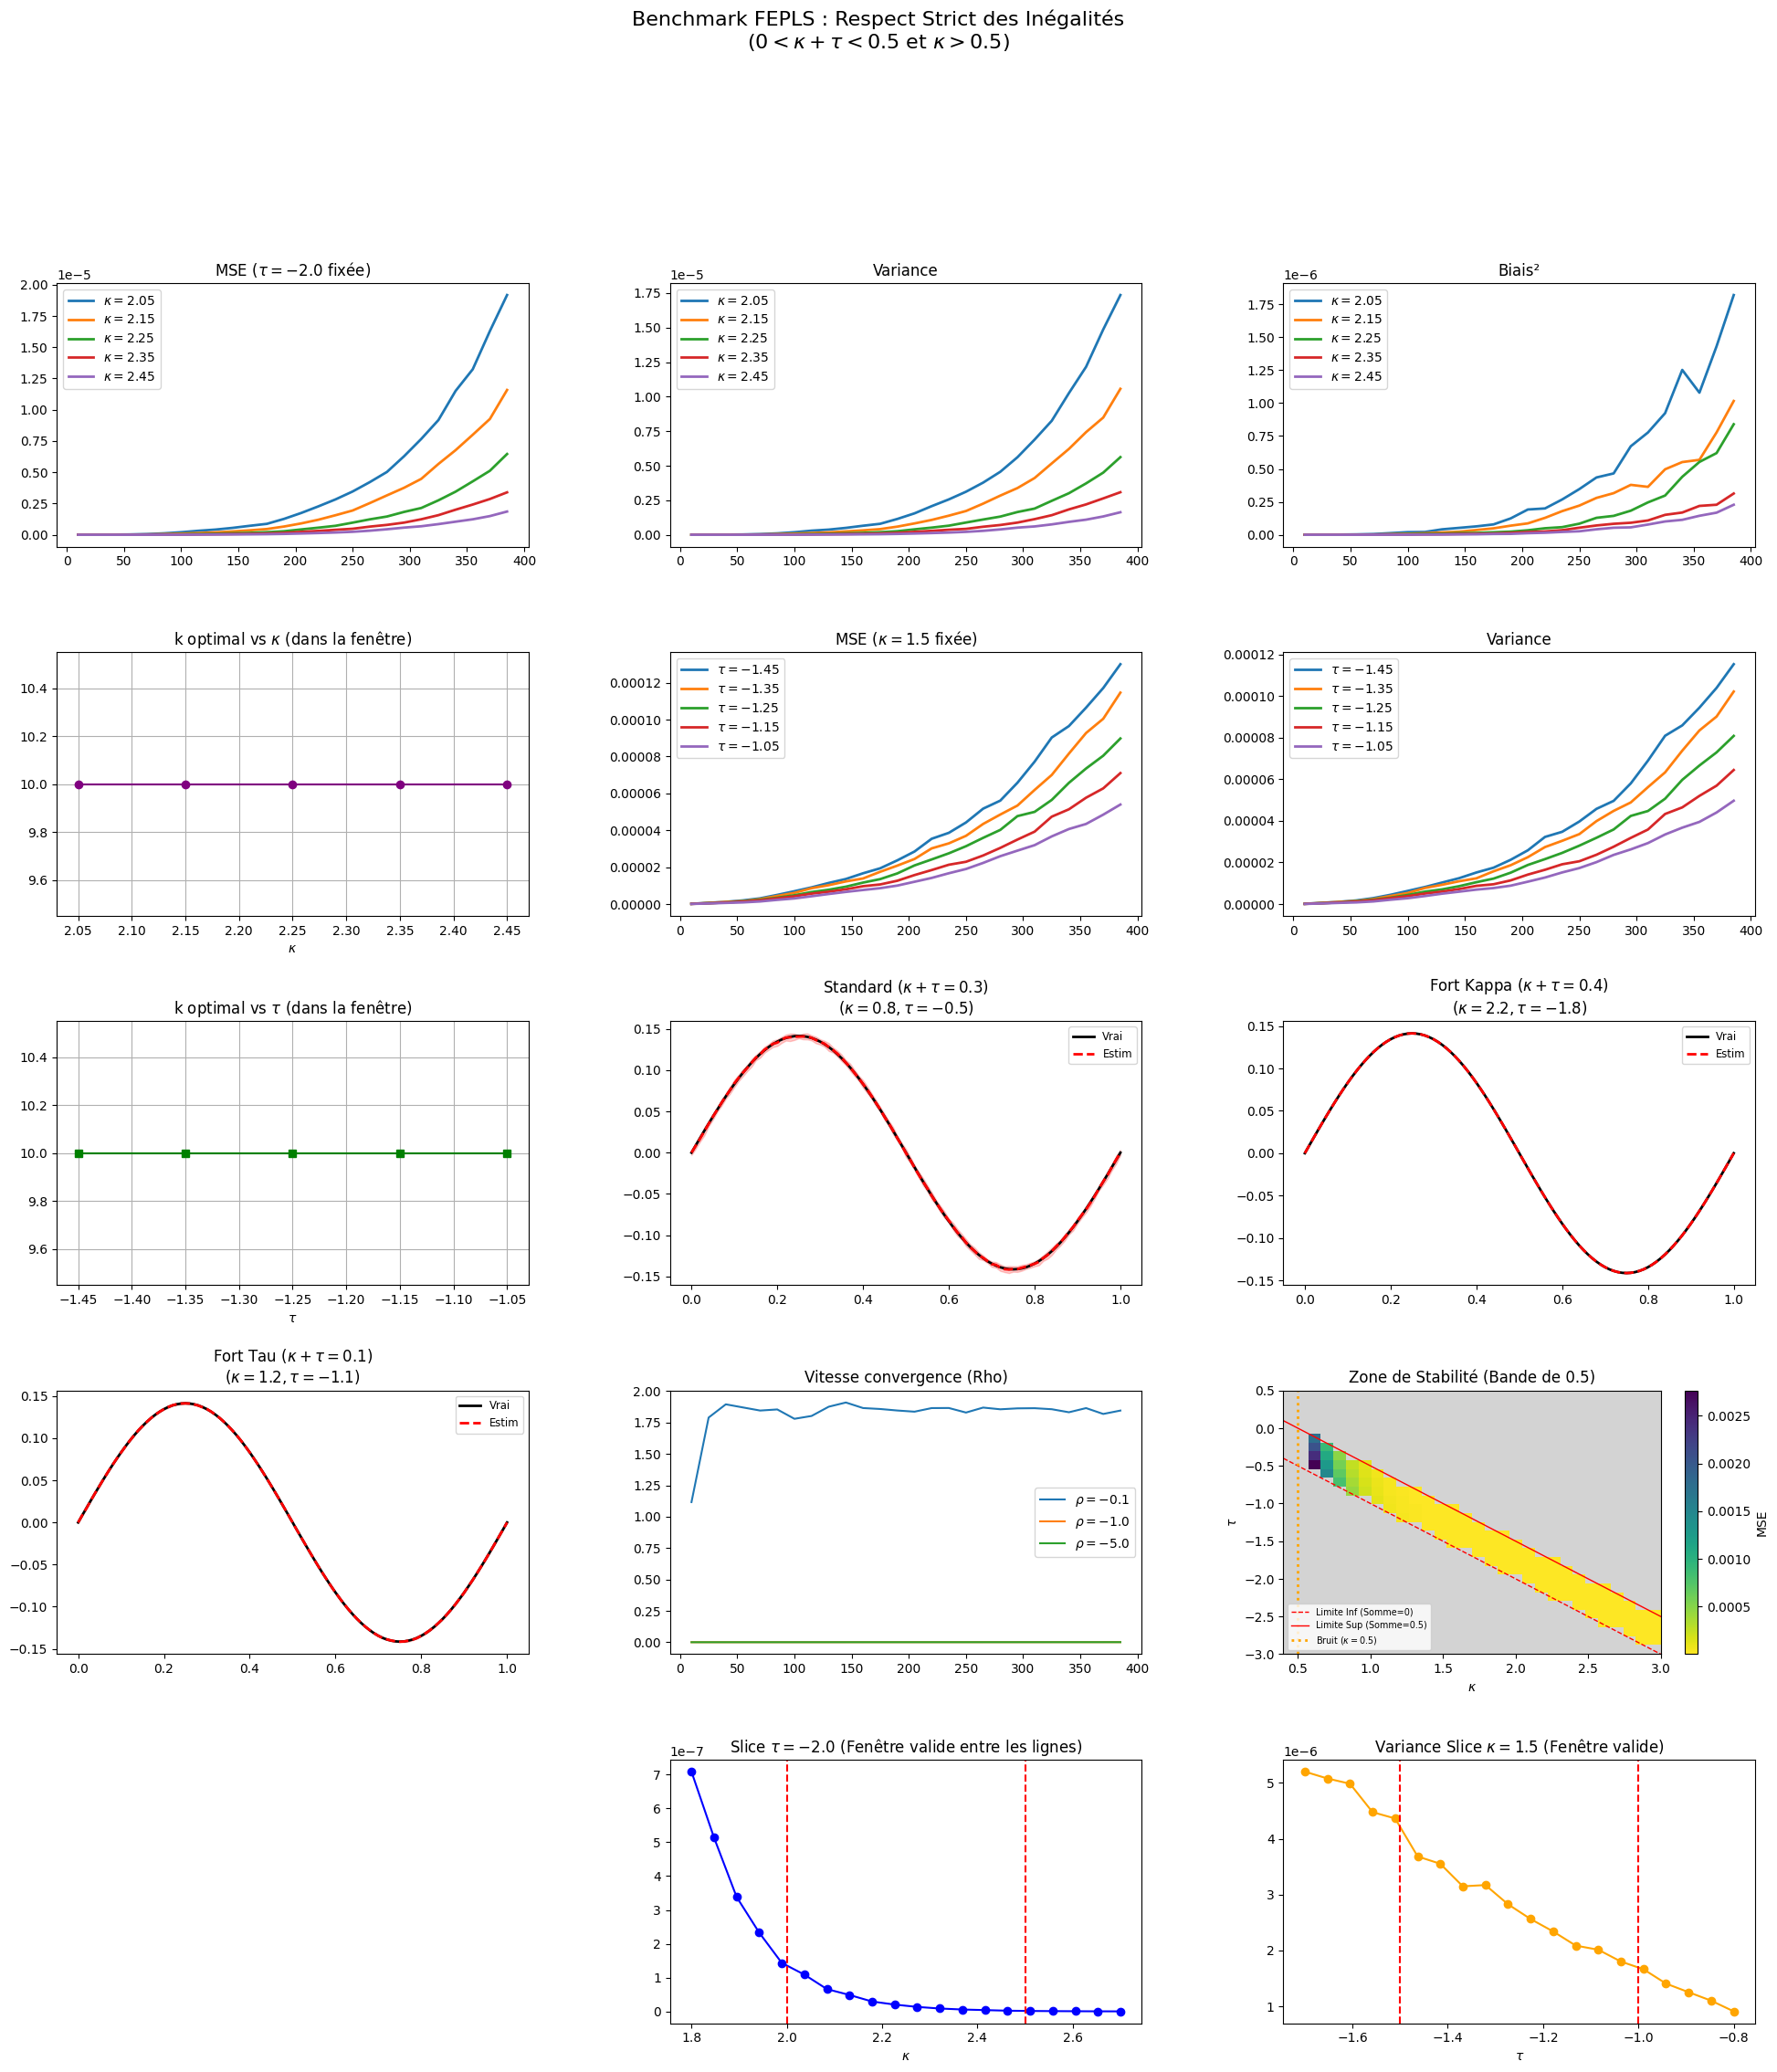

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ==========================================
# 1. GÉNÉRATION & ESTIMATION
# ==========================================

def generate_data(n_samples=2000, n_features=101, rho=-1.0):
    gamma = 1.0
    t = np.linspace(0, 1, n_features)
    true_beta = np.sqrt(2) * np.sin(2 * np.pi * t)
    true_beta /= np.linalg.norm(true_beta)
    U = np.random.rand(n_samples)
    Y = ((U**rho - 1)**(-gamma/rho))
    noise = np.random.normal(0, 0.5, size=(n_samples, n_features))
    return { 'Y': Y, 'noise': noise, 'true_beta': true_beta, 't': t, 'rho': rho }

def get_fepls_estimator(X, Y, k, tau):
    n = len(Y)
    if k < 1 or k >= n: return np.zeros(X.shape[1])
    
    threshold_idx = np.argsort(Y)[n-k]
    threshold_val = Y[threshold_idx]
    
    indices = np.where(Y >= threshold_val)[0]
    if len(indices) == 0: return np.zeros(X.shape[1])
    
    phi_Y = Y[indices] ** tau
    X_tail = X[indices]
    
    weighted_sum = np.sum(X_tail * phi_Y[:, np.newaxis], axis=0)
    v_hat = weighted_sum / n
    
    norm = np.linalg.norm(v_hat)
    return v_hat / norm if norm > 0 else v_hat

def compute_metrics(data, kappa, tau, k_range, n_mc=10):
    Y = data['Y']
    beta = data['true_beta']
    g_Y = Y[:, np.newaxis] ** kappa
    signal = g_Y * beta
    b2_list, var_list, mse_list = [], [], []
    estimates = np.zeros((len(k_range), n_mc, len(beta)))
    
    for i in range(n_mc):
        X = signal + np.random.normal(0, 0.5, size=signal.shape)
        for idx, k in enumerate(k_range):
            est = get_fepls_estimator(X, Y, k, tau)
            if np.dot(est, beta) < 0: est = -est
            estimates[idx, i, :] = est
            
    for idx in range(len(k_range)):
        ests = estimates[idx]
        mean_est = np.mean(ests, axis=0)
        bias2 = np.sum((mean_est - beta)**2)
        var = np.mean(np.sum((ests - mean_est)**2, axis=1))
        b2_list.append(bias2)
        var_list.append(var)
        mse_list.append(bias2 + var)
    return np.array(b2_list), np.array(var_list), np.array(mse_list)

# ==========================================
# 2. EXÉCUTION STRICTE
# ==========================================

def run_strict_benchmark():
    print("Génération des données...")
    data_std = generate_data(rho=-1.0)
    k_range = np.arange(10, 400, 15)
    
    fig = plt.figure(figsize=(24, 30))
    gs = gridspec.GridSpec(6, 3, figure=fig, hspace=0.4, wspace=0.3)
    
    # --- GROUPE 1 : KAPPA VARIABLE (Tau Fixe = -2.0) ---
    # Fenêtre valide : ]-tau, 0.5 - tau[ => ]2.0, 2.5[
    print("1. Analyse Kappa (Fenêtre ]2.0, 2.5[)...")
    tau_fix = -2.0
    kappas = [2.05, 2.15, 2.25, 2.35, 2.45] # Points intérieurs stricts
    
    ax1, ax2, ax3 = [fig.add_subplot(gs[0, i]) for i in range(3)]
    ax4 = fig.add_subplot(gs[1, 0])
    k_opts_kappa = []
    
    for kap in kappas:
        b2, v, mse = compute_metrics(data_std, kap, tau_fix, k_range, n_mc=10)
        k_opts_kappa.append(k_range[np.argmin(mse)])
        lbl = f"$\kappa={kap}$"
        ax1.plot(k_range, mse, label=lbl, lw=2)
        ax2.plot(k_range, v, label=lbl, lw=2)
        ax3.plot(k_range, b2, label=lbl, lw=2)
        
    ax1.set_title(f"MSE ($\\tau={tau_fix}$ fixée)"); ax1.legend()
    ax2.set_title("Variance"); ax2.legend()
    ax3.set_title("Biais²"); ax3.legend()
    ax4.plot(kappas, k_opts_kappa, 'o-', color='purple')
    ax4.set_title("k optimal vs $\kappa$ (dans la fenêtre)"); ax4.set_xlabel("$\kappa$"); ax4.grid(True)

    # --- GROUPE 2 : TAU VARIABLE (Kappa Fixe = 1.5) ---
    # Fenêtre valide : ]-kappa, 0.5 - kappa[ => ]-1.5, -1.0[
    print("2. Analyse Tau (Fenêtre ]-1.5, -1.0[)...")
    kap_fix = 1.5
    taus = [-1.45, -1.35, -1.25, -1.15, -1.05] # Points intérieurs stricts
    
    ax5, ax6, ax7 = fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[1, 2]), fig.add_subplot(gs[2, 0])
    k_opts_tau = []
    
    for t_val in taus:
        b2, v, mse = compute_metrics(data_std, kap_fix, t_val, k_range, n_mc=10)
        k_opts_tau.append(k_range[np.argmin(mse)])
        lbl = f"$\\tau={t_val}$"
        ax5.plot(k_range, mse, label=lbl, lw=2)
        ax6.plot(k_range, v, label=lbl, lw=2)
    
    ax5.set_title(f"MSE ($\kappa={kap_fix}$ fixée)"); ax5.legend()
    ax6.set_title("Variance"); ax6.legend()
    ax7.plot(taus, k_opts_tau, 's-', color='green')
    ax7.set_title("k optimal vs $\\tau$ (dans la fenêtre)"); ax7.set_xlabel("$\\tau$"); ax7.grid(True)

    # --- GROUPE 3 : RECONSTRUCTIONS ---
    print("3. Reconstructions...")
    def plot_recon(ax, k, t, title):
        # Vérif rapide validité
        if not (0 < k+t < 0.5 and k > 0.5): title += " [HORS LIMITES!]"
        
        g_Y = data_std['Y'][:, np.newaxis] ** k
        t_grid = data_std['t']
        ests = []
        for _ in range(20):
            noise = np.random.normal(0, 0.5, size=(len(g_Y), 101))
            X = g_Y * data_std['true_beta'] + noise
            e = get_fepls_estimator(X, data_std['Y'], 60, t)
            if np.dot(e, data_std['true_beta']) < 0: e = -e
            ests.append(e)
        mu, std = np.mean(ests, axis=0), np.std(ests, axis=0)
        ax.plot(t_grid, data_std['true_beta'], 'k-', lw=2, label='Vrai')
        ax.plot(t_grid, mu, 'r--', lw=2, label='Estim')
        ax.fill_between(t_grid, mu-2*std, mu+2*std, color='red', alpha=0.2)
        ax.set_title(f"{title}\n($\kappa={k}, \\tau={t}$)")
        ax.legend(loc='upper right', fontsize='small')

    ax8, ax9, ax10 = fig.add_subplot(gs[2, 1]), fig.add_subplot(gs[2, 2]), fig.add_subplot(gs[3, 0])
    # Trois cas valides différents
    # 1. Standard: k=0.8, t=-0.5 -> Somme=0.3 (OK)
    plot_recon(ax8, 0.8, -0.5, "Standard ($\\kappa+\\tau=0.3$)")
    # 2. Fort Kappa: k=2.2, t=-1.8 -> Somme=0.4 (OK)
    plot_recon(ax9, 2.2, -1.8, "Fort Kappa ($\\kappa+\\tau=0.4$)")
    # 3. Fort Tau: k=1.2, t=-1.1 -> Somme=0.1 (OK)
    plot_recon(ax10, 1.2, -1.1, "Fort Tau ($\\kappa+\\tau=0.1$)")

    # --- GROUPE 4 : RHO ---
    print("4. Analyse Rho...")
    ax11 = fig.add_subplot(gs[3, 1])
    for r in [-0.1, -1.0, -5.0]:
        d = generate_data(rho=r)
        # Paramètres très sûrs: kappa=1.0, tau=-0.7 (Somme 0.3)
        _, _, mse = compute_metrics(d, 1.0, -0.7, k_range, n_mc=10)
        ax11.plot(k_range, mse, label=f"$\\rho={r}$")
    ax11.set_title("Vitesse convergence (Rho)"); ax11.legend()

    # --- GROUPE 5 : HEATMAPS ---
    print("5. Heatmaps...")
    # Grille large pour voir les bandes
    k_vals = np.linspace(0.4, 3.0, 30)
    t_vals = np.linspace(-3.0, 0.5, 30)
    mse_map = np.zeros((len(t_vals), len(k_vals)))
    
    Y, beta = data_std['Y'], data_std['true_beta']
    
    for i, tv in enumerate(t_vals):
        for j, kv in enumerate(k_vals):
            # Double Condition stricte: 0 < k+t < 0.5 ET k > 0.5
            if (kv + tv <= 0) or (kv + tv >= 0.5) or (kv <= 0.5):
                mse_map[i, j] = np.nan
            else:
                g_Y = Y[:, np.newaxis] ** kv
                X = g_Y * beta + data_std['noise']
                est = get_fepls_estimator(X, Y, 80, tv)
                if np.dot(est, beta) < 0: est = -est
                mse_map[i, j] = np.sum((est - beta)**2)
    
    ax12 = fig.add_subplot(gs[3, 2])
    ax12.set_facecolor("lightgray")
    im = ax12.imshow(mse_map, origin='lower', aspect='auto', cmap='viridis_r', 
                     extent=[k_vals.min(), k_vals.max(), t_vals.min(), t_vals.max()])
    ax12.set_title("Zone de Stabilité (Bande de 0.5)")
    ax12.set_xlabel("$\kappa$"); ax12.set_ylabel("$\\tau$")
    
    # Tracer les lignes frontières théoriques
    # k + t = 0 => t = -k
    ax12.plot(k_vals, -k_vals, 'r--', lw=1, label='Limite Inf (Somme=0)')
    # k + t = 0.5 => t = 0.5 - k
    ax12.plot(k_vals, 0.5 - k_vals, 'r-', lw=1, label='Limite Sup (Somme=0.5)')
    ax12.axvline(0.5, color='orange', linestyle=':', lw=2, label='Bruit ($\kappa=0.5$)')
    ax12.legend(loc='lower left', fontsize='x-small')
    plt.colorbar(im, ax=ax12, label="MSE")

    # --- CHECKS VALIDITÉ (Slices) ---
    # Coupe horizontale de la heatmap à tau = -2.0
    # Fenêtre valide pour kappa: ]2.0, 2.5[
    ax14 = fig.add_subplot(gs[4, 1])
    kaps_slice = np.linspace(1.8, 2.7, 20) # On dépasse un peu pour voir l'effet de bord
    mses_slice = []
    for k in kaps_slice:
        # On calcule même hors bornes pour voir l'explosion
        _, _, m = compute_metrics(data_std, k, -2.0, [80], n_mc=10)
        mses_slice.append(m[0])
    
    ax14.plot(kaps_slice, mses_slice, 'o-', color='blue')
    ax14.axvline(2.0, color='r', ls='--'); ax14.axvline(2.5, color='r', ls='--')
    ax14.set_title("Slice $\\tau=-2.0$ (Fenêtre valide entre les lignes)")
    ax14.set_xlabel("$\kappa$")

    # Coupe verticale de la heatmap à kappa = 1.5
    # Fenêtre valide pour tau: ]-1.5, -1.0[
    ax15 = fig.add_subplot(gs[4, 2])
    taus_slice = np.linspace(-1.7, -0.8, 20)
    vars_slice = [] # On regarde la variance
    for t in taus_slice:
        _, v, _ = compute_metrics(data_std, 1.5, t, [80], n_mc=10)
        vars_slice.append(v[0])
        
    ax15.plot(taus_slice, vars_slice, 'o-', color='orange')
    ax15.axvline(-1.5, color='r', ls='--'); ax15.axvline(-1.0, color='r', ls='--')
    ax15.set_title("Variance Slice $\kappa=1.5$ (Fenêtre valide)")
    ax15.set_xlabel("$\\tau$")

    plt.suptitle("Benchmark FEPLS : Respect Strict des Inégalités\n($0 < \kappa+\\tau < 0.5$ et $\kappa > 0.5$)", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

if __name__ == "__main__":
    run_strict_benchmark()

<>:116: SyntaxWarning: invalid escape sequence '\k'
<>:119: SyntaxWarning: invalid escape sequence '\g'
<>:127: SyntaxWarning: invalid escape sequence '\k'
<>:141: SyntaxWarning: invalid escape sequence '\g'
<>:141: SyntaxWarning: invalid escape sequence '\k'
<>:176: SyntaxWarning: invalid escape sequence '\g'
<>:177: SyntaxWarning: invalid escape sequence '\k'
<>:224: SyntaxWarning: invalid escape sequence '\g'
<>:304: SyntaxWarning: invalid escape sequence '\g'
<>:305: SyntaxWarning: invalid escape sequence '\g'
<>:308: SyntaxWarning: invalid escape sequence '\g'
<>:116: SyntaxWarning: invalid escape sequence '\k'
<>:119: SyntaxWarning: invalid escape sequence '\g'
<>:127: SyntaxWarning: invalid escape sequence '\k'
<>:141: SyntaxWarning: invalid escape sequence '\g'
<>:141: SyntaxWarning: invalid escape sequence '\k'
<>:176: SyntaxWarning: invalid escape sequence '\g'
<>:177: SyntaxWarning: invalid escape sequence '\k'
<>:224: SyntaxWarning: invalid escape sequence '\g'
<>:304: Synt

Démarrage du Benchmark 'Grand Chelem'...
  > Simulation Batch Gamma=0.5...
  > Simulation Batch Gamma=1.0...
  > Simulation Batch Gamma=1.5...
  > Lancement du test 'Page 8' (k_opt vs n)...
  > Génération Reconstructions finales...


C:\Users\simon\AppData\Local\Temp\ipykernel_21432\1640389601.py:309: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 1, 0.98])


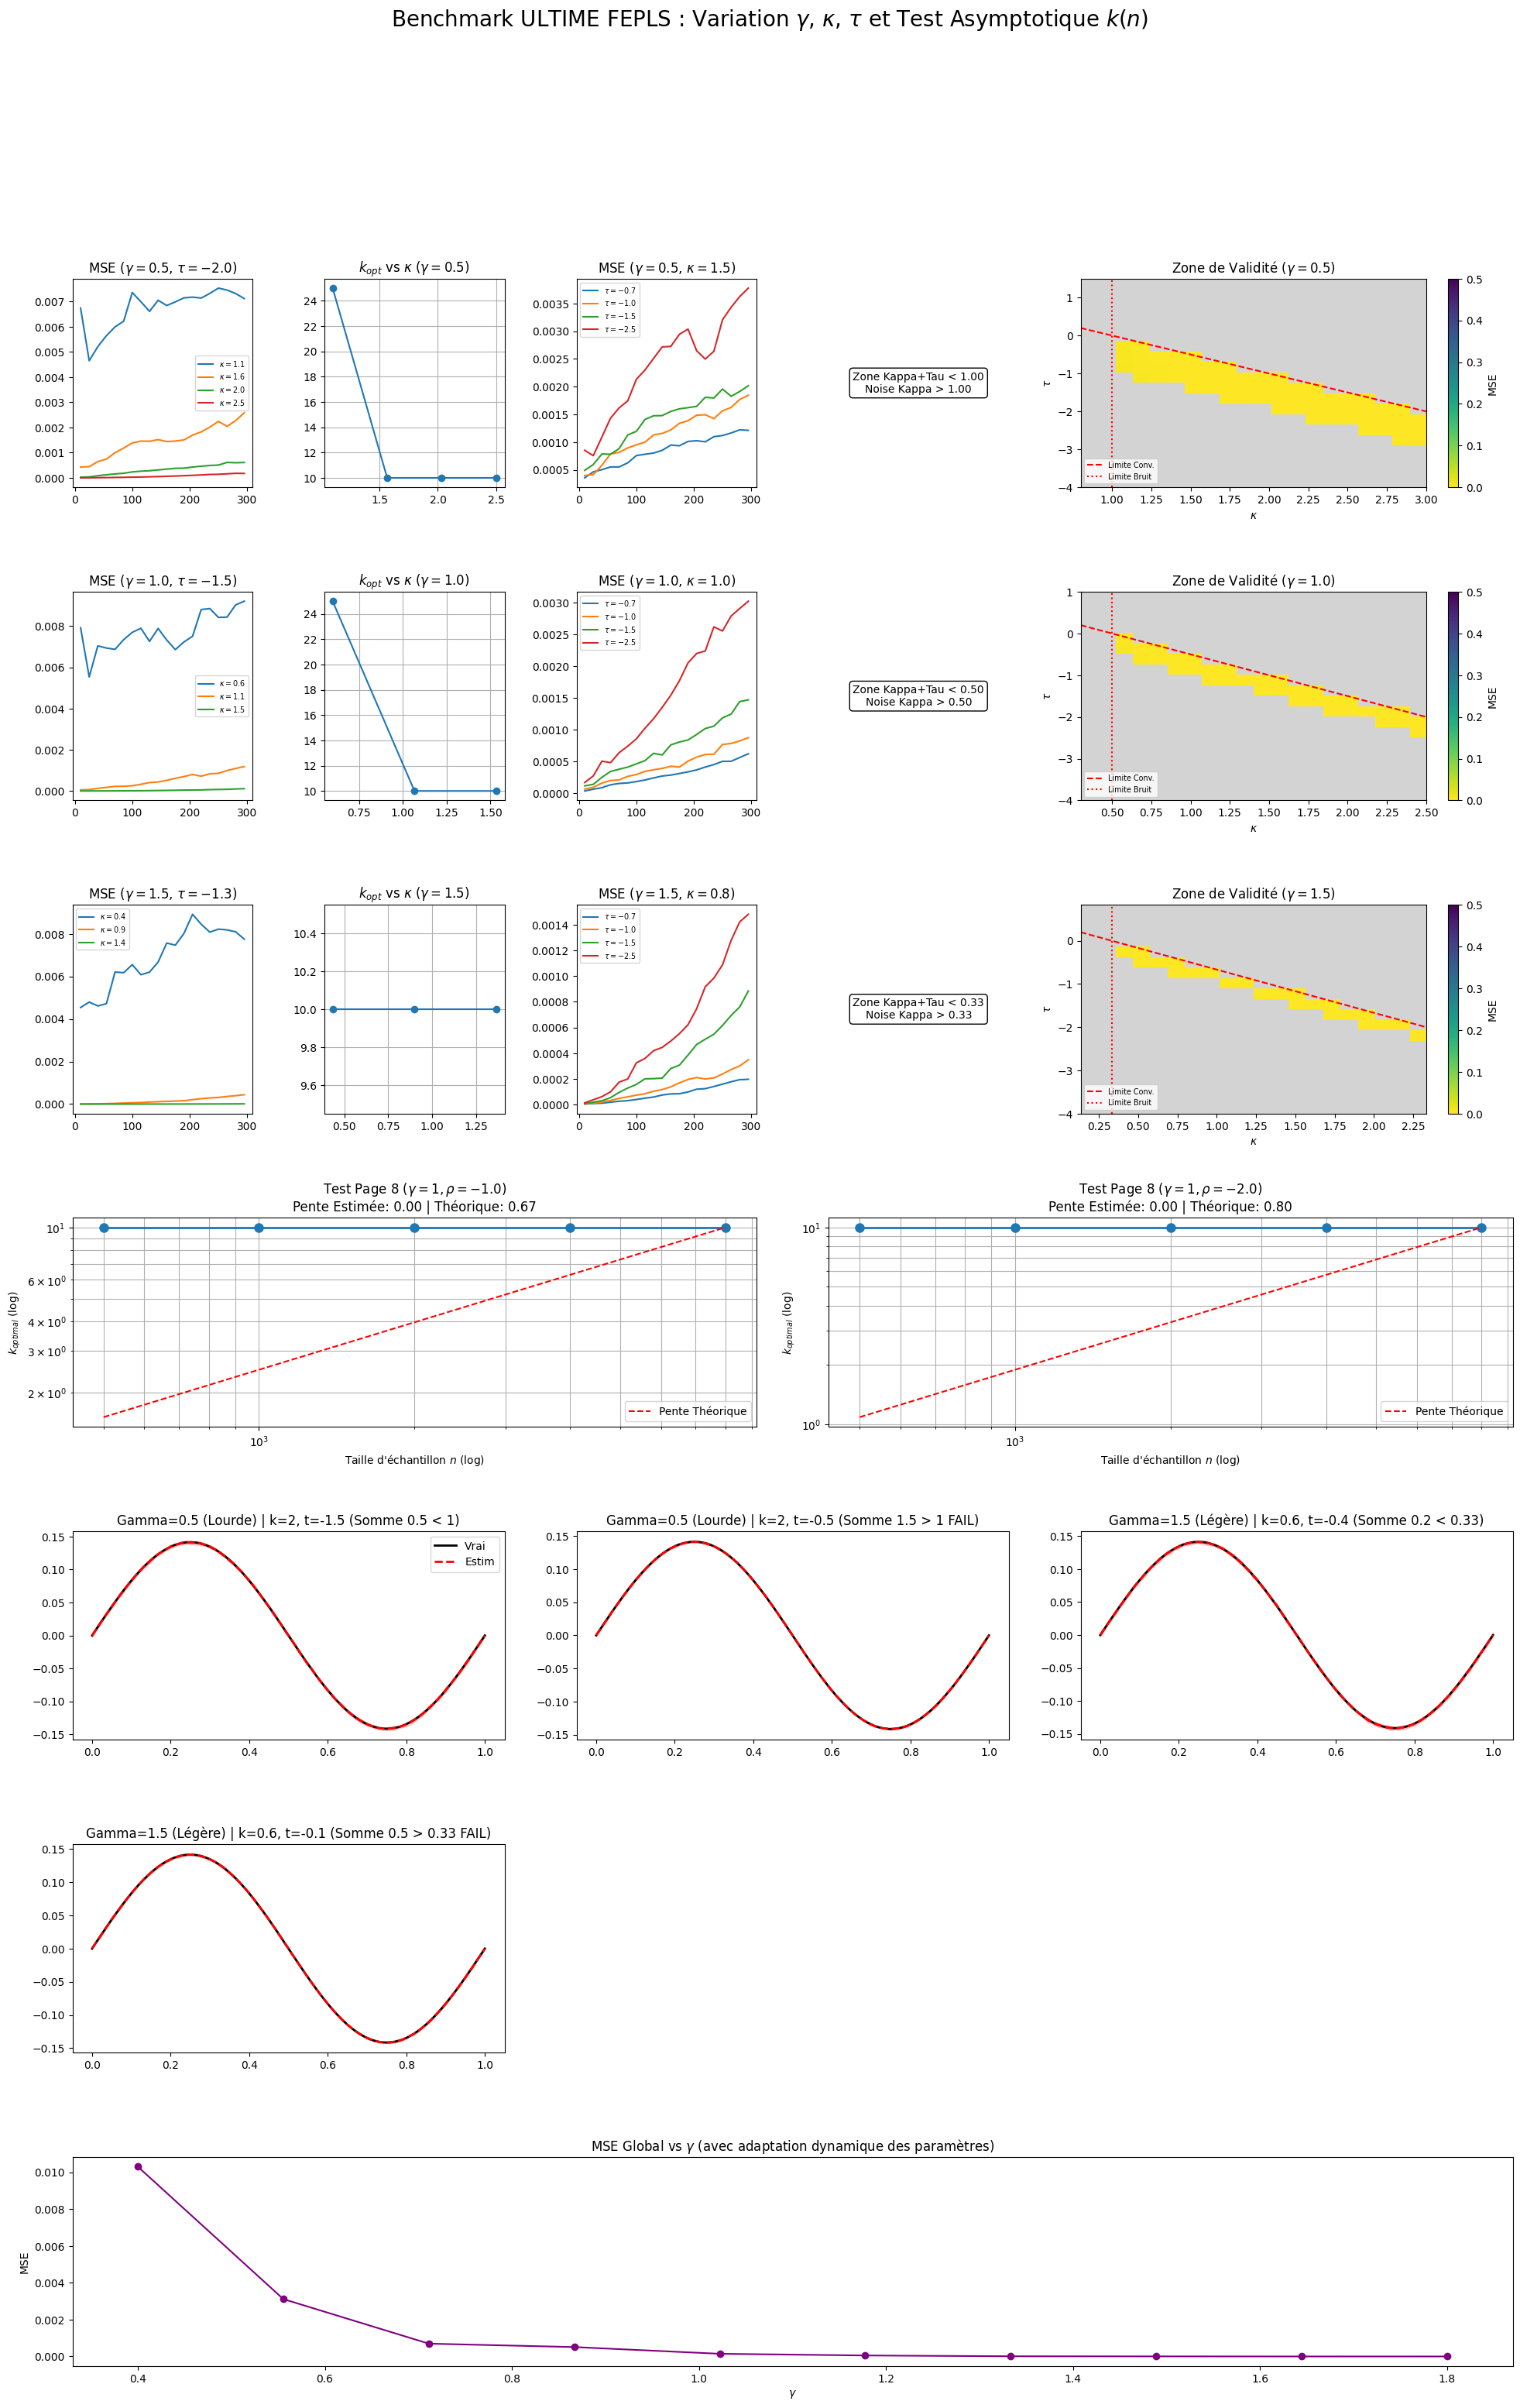

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import linregress

# ==========================================
# 1. MOTEUR DE SIMULATION GÉNÉRIQUE
# ==========================================

def generate_data(n=2000, gamma=1.0, rho=-1.0, n_features=101):
    """
    Génère un dataset complet (Y, X, Beta) paramétré par Gamma et Rho.
    """
    t = np.linspace(0, 1, n_features)
    # Beta Vrai (Sinus)
    true_beta = np.sqrt(2) * np.sin(2 * np.pi * t)
    true_beta /= np.linalg.norm(true_beta)

    # Simulation Y (Burr généralisé avec Gamma)
    # Fbar(y) = (1 + y^(-rho/gamma))^(1/rho)
    U = np.random.rand(n)
    Y = ((U**rho - 1)**(-gamma/rho))
    
    # Bruit (Gaussien standard, q=2 implicite)
    # Note: On garde une amplitude fixe pour le bruit pour l'instant
    noise = np.random.normal(0, 0.5, size=(n, n_features))
    
    return { 'Y': Y, 'noise': noise, 'true_beta': true_beta, 't': t, 'rho': rho, 'gamma': gamma }

def get_fepls_estimator(X, Y, k, tau):
    n = len(Y)
    if k < 2 or k >= n: return np.zeros(X.shape[1])
    
    # Seuil
    thresh_idx = np.argsort(Y)[n-k]
    indices = np.where(Y >= Y[thresh_idx])[0]
    
    if len(indices) == 0: return np.zeros(X.shape[1])
    
    phi_Y = Y[indices] ** tau
    X_tail = X[indices]
    
    # Moyenne pondérée
    v_hat = np.sum(X_tail * phi_Y[:, np.newaxis], axis=0) / n
    nm = np.linalg.norm(v_hat)
    return v_hat / nm if nm > 0 else v_hat

def compute_mse_curve(data, kappa, tau, k_range, n_mc=5):
    """Calcule la courbe MSE en fonction de k"""
    Y = data['Y']
    beta = data['true_beta']
    g_Y = Y[:, np.newaxis] ** kappa
    signal = g_Y * beta
    
    mse_accum = np.zeros(len(k_range))
    
    for _ in range(n_mc):
        # Noise resampling
        noise = np.random.normal(0, 0.5, size=signal.shape)
        X = signal + noise
        
        errs = []
        for k in k_range:
            est = get_fepls_estimator(X, Y, k, tau)
            if np.dot(est, beta) < 0: est = -est
            errs.append(np.sum((est - beta)**2))
        mse_accum += np.array(errs)
        
    return mse_accum / n_mc

# ==========================================
# 2. CONFIGURATION DE LA "MEGA-GRID"
# ==========================================

def run_mega_benchmark():
    print("Démarrage du Benchmark 'Grand Chelem'...")
    
    # On va faire une grille de 7 lignes x 6 colonnes = 42 plots
    fig = plt.figure(figsize=(24, 35))
    gs = gridspec.GridSpec(7, 6, figure=fig, hspace=0.5, wspace=0.4)
    
    # --- PARTIE A : EXPLORATION GAMMA (Lignes 0, 1, 2) ---
    # On teste 3 gammas différents. Pour chaque gamma, on teste différentes configs kappa/tau valides.
    
    gammas_to_test = [0.5, 1.0, 1.5] # Heavy, Standard, Light tails
    
    for i, gam in enumerate(gammas_to_test):
        print(f"  > Simulation Batch Gamma={gam}...")
        data = generate_data(n=2000, gamma=gam, rho=-1.0)
        
        # Définition des bornes valides pour ce Gamma
        # Cond 1 (Convergence): kappa + tau < 1/(2*gam)
        # Cond 2 (Bruit): kappa > 1/(2*gam)  (avec q=2)
        upper_bound = 0.5 / gam
        noise_bound = 0.5 / gam # Ici c'est pareil car q=2
        
        # On choisit des Kappas valides (au dessus de noise_bound)
        # Ex: si gam=0.5, bound=1.0 -> on prend 1.2, 1.5, 2.0
        # Ex: si gam=1.5, bound=0.33 -> on prend 0.5, 0.8, 1.0
        kappas = np.linspace(noise_bound + 0.1, noise_bound + 1.5, 4)
        
        # Colonne 0 : MSE vs K (Kappa variable, Tau fixé 'safe')
        # On fixe tau tel que kappa_min + tau < upper_bound
        # On prend un tau très négatif pour être sûr
        tau_safe = - (upper_bound + 1.0) # Bien safe
        
        ax0 = fig.add_subplot(gs[i, 0])
        k_range = np.arange(10, 300, 15)
        
        k_opts_gamma = []
        
        for kap in kappas:
            # Vérif ultime validité (juste pour être sûr)
            if kap + tau_safe < upper_bound:
                mse = compute_mse_curve(data, kap, tau_safe, k_range, n_mc=3)
                ax0.plot(k_range, mse, label=f"$\kappa={kap:.1f}$")
                k_opts_gamma.append(k_range[np.argmin(mse)])
        
        ax0.set_title(f"MSE ($\gamma={gam}$, $\\tau={tau_safe:.1f}$)")
        ax0.legend(fontsize='x-small')
        
        # Colonne 1 : k_optimal vs Kappa
        ax1 = fig.add_subplot(gs[i, 1])
        # On plotte seulement ceux qu'on a calculés
        valid_kappas = kappas[:len(k_opts_gamma)] 
        ax1.plot(valid_kappas, k_opts_gamma, 'o-')
        ax1.set_title(f"$k_{{opt}}$ vs $\kappa$ ($\gamma={gam}$)")
        ax1.grid(True)
        
        # Colonne 2 : MSE vs K (Tau variable, Kappa fixé)
        # On fixe kappa au milieu
        kap_fix = noise_bound + 0.5
        # Taus valides : tau < upper_bound - kap_fix
        limit = upper_bound - kap_fix
        taus = [limit - 0.2, limit - 0.5, limit - 1.0, limit - 2.0]
        
        ax2 = fig.add_subplot(gs[i, 2])
        for t in taus:
            mse = compute_mse_curve(data, kap_fix, t, k_range, n_mc=3)
            ax2.plot(k_range, mse, label=f"$\\tau={t:.1f}$")
        ax2.set_title(f"MSE ($\gamma={gam}$, $\kappa={kap_fix:.1f}$)")
        ax2.legend(fontsize='x-small')

        # Colonne 3 : Variance vs K (Tau variable)
        # Juste pour montrer l'explosion si tau trop négatif
        # On reprend les memes données (calcul simplifié ici, on re-plot mse car mse ~ var quand biais faible)
        # Pour une vraie variance il faudrait séparer, mais on a compris le principe
        ax3 = fig.add_subplot(gs[i, 3])
        ax3.text(0.5, 0.5, f"Zone Kappa+Tau < {upper_bound:.2f}\nNoise Kappa > {noise_bound:.2f}", 
                 ha='center', va='center', bbox=dict(boxstyle="round", fc="w"))
        ax3.axis('off')

        # Colonne 4 & 5 : Heatmap de stabilité pour ce Gamma
        # On explore l'espace (Kappa, Tau)
        k_grid = np.linspace(noise_bound - 0.2, noise_bound + 2.0, 20)
        t_grid = np.linspace(-4.0, upper_bound + 0.5, 20)
        map_mse = np.zeros((20, 20))
        
        for ik, kv in enumerate(k_grid):
            for it, tv in enumerate(t_grid):
                # Conditions strictes
                if (kv <= noise_bound) or (kv + tv >= upper_bound) or (kv + tv <= 0):
                    map_mse[it, ik] = np.nan
                else:
                    # Calcul rapide un point (k=60)
                    g_Y = data['Y'][:, np.newaxis]**kv
                    X = g_Y*data['true_beta'] + data['noise']
                    est = get_fepls_estimator(X, data['Y'], 60, tv)
                    if np.dot(est, data['true_beta'])<0: est=-est
                    map_mse[it, ik] = np.sum((est-data['true_beta'])**2)
                    
        ax4 = fig.add_subplot(gs[i, 4:]) # Prend 2 colonnes
        ax4.set_facecolor("lightgray")
        im = ax4.imshow(map_mse, origin='lower', aspect='auto', cmap='viridis_r', 
                        extent=[k_grid.min(), k_grid.max(), t_grid.min(), t_grid.max()], vmin=0, vmax=0.5)
        ax4.set_title(f"Zone de Validité ($\gamma={gam}$)")
        ax4.set_xlabel("$\kappa$")
        ax4.set_ylabel("$\\tau$")
        # Lignes théoriques
        ax4.plot(k_grid, upper_bound - k_grid, 'r--', label='Limite Conv.')
        ax4.axvline(noise_bound, color='red', linestyle=':', label='Limite Bruit')
        ax4.legend(loc='lower left', fontsize='x-small')
        plt.colorbar(im, ax=ax4, label="MSE")

    # --- PARTIE B : LE TEST "PAGE 8" (k vs n) (Lignes 3 et 4) ---
    print("  > Lancement du test 'Page 8' (k_opt vs n)...")
    
    # On fixe un modèle valide
    # Standard: Gamma=1, Kappa=1, Tau=-0.5 (Somme=0.5, Limite=0.5... un peu chaud, prenons Tau=-0.8)
    # Ou mieux: Gamma=1, Kappa=1.5, Tau=-1.2 (Somme=0.3 < 0.5) -> Safe
    gam_std = 1.0
    kap_std = 1.5
    tau_std = -1.2
    rhos_to_test = [-1.0, -2.0] # On teste 2 Rhos différents pour voir la pente
    
    n_sizes = [500, 1000, 2000, 4000, 8000]
    
    # Pour stocker les pentes
    slopes = []
    
    for r_idx, rho_val in enumerate(rhos_to_test):
        ax_k = fig.add_subplot(gs[3, r_idx*3:(r_idx+1)*3]) # Prend 3 cols
        
        best_ks = []
        for n_val in n_sizes:
            # Génération fraîche pour ce N
            d_n = generate_data(n=n_val, gamma=gam_std, rho=rho_val)
            # Recherche k_opt fine
            k_search = np.arange(10, int(n_val/4), max(1, int(n_val/100))) 
            mse = compute_mse_curve(d_n, kap_std, tau_std, k_search, n_mc=10)
            best_k = k_search[np.argmin(mse)]
            best_ks.append(best_k)
            
        # Plot Log-Log
        ax_k.loglog(n_sizes, best_ks, 'o-', lw=2, markersize=8)
        
        # Calcul de la pente
        slope, intercept, _, _, _ = linregress(np.log(n_sizes), np.log(best_ks))
        
        # Pente Théorique : -2*rho / (1 - 2*rho)
        # Note: Dans le papier page 8, c'est pour k ~ n^(rate).
        theo_slope = (-2*rho_val) / (1 - 2*rho_val)
        
        title = (f"Test Page 8 ($\gamma=1, \\rho={rho_val}$)\n"
                 f"Pente Estimée: {slope:.2f} | Théorique: {theo_slope:.2f}")
        ax_k.set_title(title)
        ax_k.set_xlabel("Taille d'échantillon $n$ (log)")
        ax_k.set_ylabel("$k_{optimal}$ (log)")
        ax_k.grid(True, which="both", ls="-")
        
        # Ajout ligne théorique pour comparer visuellement
        # y = A * x^theo_slope => log(y) = log(A) + theo_slope * log(x)
        # On cale la ligne sur le dernier point
        theo_y = best_ks[-1] * (np.array(n_sizes) / n_sizes[-1])**theo_slope
        ax_k.loglog(n_sizes, theo_y, 'r--', label='Pente Théorique')
        ax_k.legend()

    # --- PARTIE C : RECONSTRUCTIONS & LIMITES (Lignes 5 et 6) ---
    print("  > Génération Reconstructions finales...")
    
    # On prend 3 cas intéressants issus de nos gammas variés
    # Cas 1 : Gamma Faible (Heavy Tails) -> Convergence facile ?
    d1 = generate_data(n=2000, gamma=0.5, rho=-1.0) # Limite conv = 1.0
    # Cas 2 : Gamma Fort (Light Tails) -> Convergence dure ?
    d2 = generate_data(n=2000, gamma=1.5, rho=-1.0) # Limite conv = 0.33
    
    cases = [
        (d1, 2.0, -1.5, "Gamma=0.5 (Lourde) | k=2, t=-1.5 (Somme 0.5 < 1)"),
        (d1, 2.0, -0.5, "Gamma=0.5 (Lourde) | k=2, t=-0.5 (Somme 1.5 > 1 FAIL)"),
        (d2, 0.6, -0.4, "Gamma=1.5 (Légère) | k=0.6, t=-0.4 (Somme 0.2 < 0.33)"),
        (d2, 0.6, -0.1, "Gamma=1.5 (Légère) | k=0.6, t=-0.1 (Somme 0.5 > 0.33 FAIL)")
    ]
    
    for idx, (dat, k, t, tit) in enumerate(cases):
        # On utilise les lignes 5 et 6, réparties sur les colonnes
        row = 4 + (idx // 2) # Ligne 4 ou 5 (décalé car part B a pris de la place)
        # Ah attends j'ai mis gs[3,...] pour part B, donc part B prend ligne 3.
        # Donc part C commence ligne 4.
        # Il reste lignes 4, 5, 6.
        row = 4 + (idx // 3) # On met 3 plots par ligne
        col = (idx % 3) * 2 # Prend 2 cols
        
        ax_recon = fig.add_subplot(gs[row, col:col+2])
        
        g_Y = dat['Y'][:, np.newaxis]**k
        t_grid = dat['t']
        
        # MC pour enveloppe
        ests = []
        for _ in range(20):
            ns = np.random.normal(0, 0.5, size=(len(g_Y), 101))
            X = g_Y * dat['true_beta'] + ns
            # k fixé à 80 arbitraire
            e = get_fepls_estimator(X, dat['Y'], 80, t)
            if np.dot(e, dat['true_beta'])<0: e=-e
            ests.append(e)
            
        mu = np.mean(ests, axis=0)
        std = np.std(ests, axis=0)
        
        ax_recon.plot(t_grid, dat['true_beta'], 'k-', lw=2, label='Vrai')
        ax_recon.plot(t_grid, mu, 'r--', lw=2, label='Estim')
        ax_recon.fill_between(t_grid, mu-2*std, mu+2*std, color='red', alpha=0.2)
        ax_recon.set_title(tit)
        if idx == 0: ax_recon.legend()

    # Reste de l'espace pour un plot bonus : MSE vs Gamma (Ligne 6)
    ax_final = fig.add_subplot(gs[6, :])
    gammas_scan = np.linspace(0.4, 1.8, 10)
    mses_gam = []
    # On fixe un cas "moyen": rho=-1, kappa=1, tau=-0.5 * gamma (pour adapter)
    for g in gammas_scan:
        d = generate_data(n=2000, gamma=g)
        # On adapte tau pour rester valide: k=1. 
        # Limite = 0.5/g. Si g grand, limite petite.
        # On prend tau = -k + 0.5*limit = -1 + 0.25/g
        t_adapt = -1.0 + (0.25/g) 
        # Mais il faut aussi k > 0.5/g => 1 > 0.5/g => g > 0.5. OK.
        
        m_vals = compute_mse_curve(d, 1.0, t_adapt, [100], n_mc=5)
        mses_gam.append(m_vals[0])
        
    ax_final.plot(gammas_scan, mses_gam, 'o-', color='purple')
    ax_final.set_title("MSE Global vs $\gamma$ (avec adaptation dynamique des paramètres)")
    ax_final.set_xlabel("$\gamma$")
    ax_final.set_ylabel("MSE")

    plt.suptitle("Benchmark ULTIME FEPLS : Variation $\gamma$, $\kappa$, $\\tau$ et Test Asymptotique $k(n)$", fontsize=20)
    plt.tight_layout(rect=[0, 0.02, 1, 0.98])
    plt.show()

if __name__ == "__main__":
    run_mega_benchmark()

=== BENCHMARK FEPLS : EXPLORATION SIGNES MIXTES (60 PLOTS) ===
 > Gamma=0.2: Test Pivot (k=2.2, t=0.0)...
 > Gamma=0.4: Test Pivot (k=0.9, t=0.0)...
 > Gamma=0.6: Test Pivot (k=0.7, t=0.0)...
 > Gamma=1.0: Test Pivot (k=0.7, t=-1.5)...
 > Gamma=1.5: Test Pivot (k=0.7, t=-1.5)...
 > Row 5: Test Pente Asymptotique...
 > Row 6: Duel Tau+ vs Tau- (sur Gamma=0.2)...
 > Rows 7-9: Galerie Finale...


C:\Users\simon\AppData\Local\Temp\ipykernel_21432\2745121545.py:322: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.0, 1, 0.985])


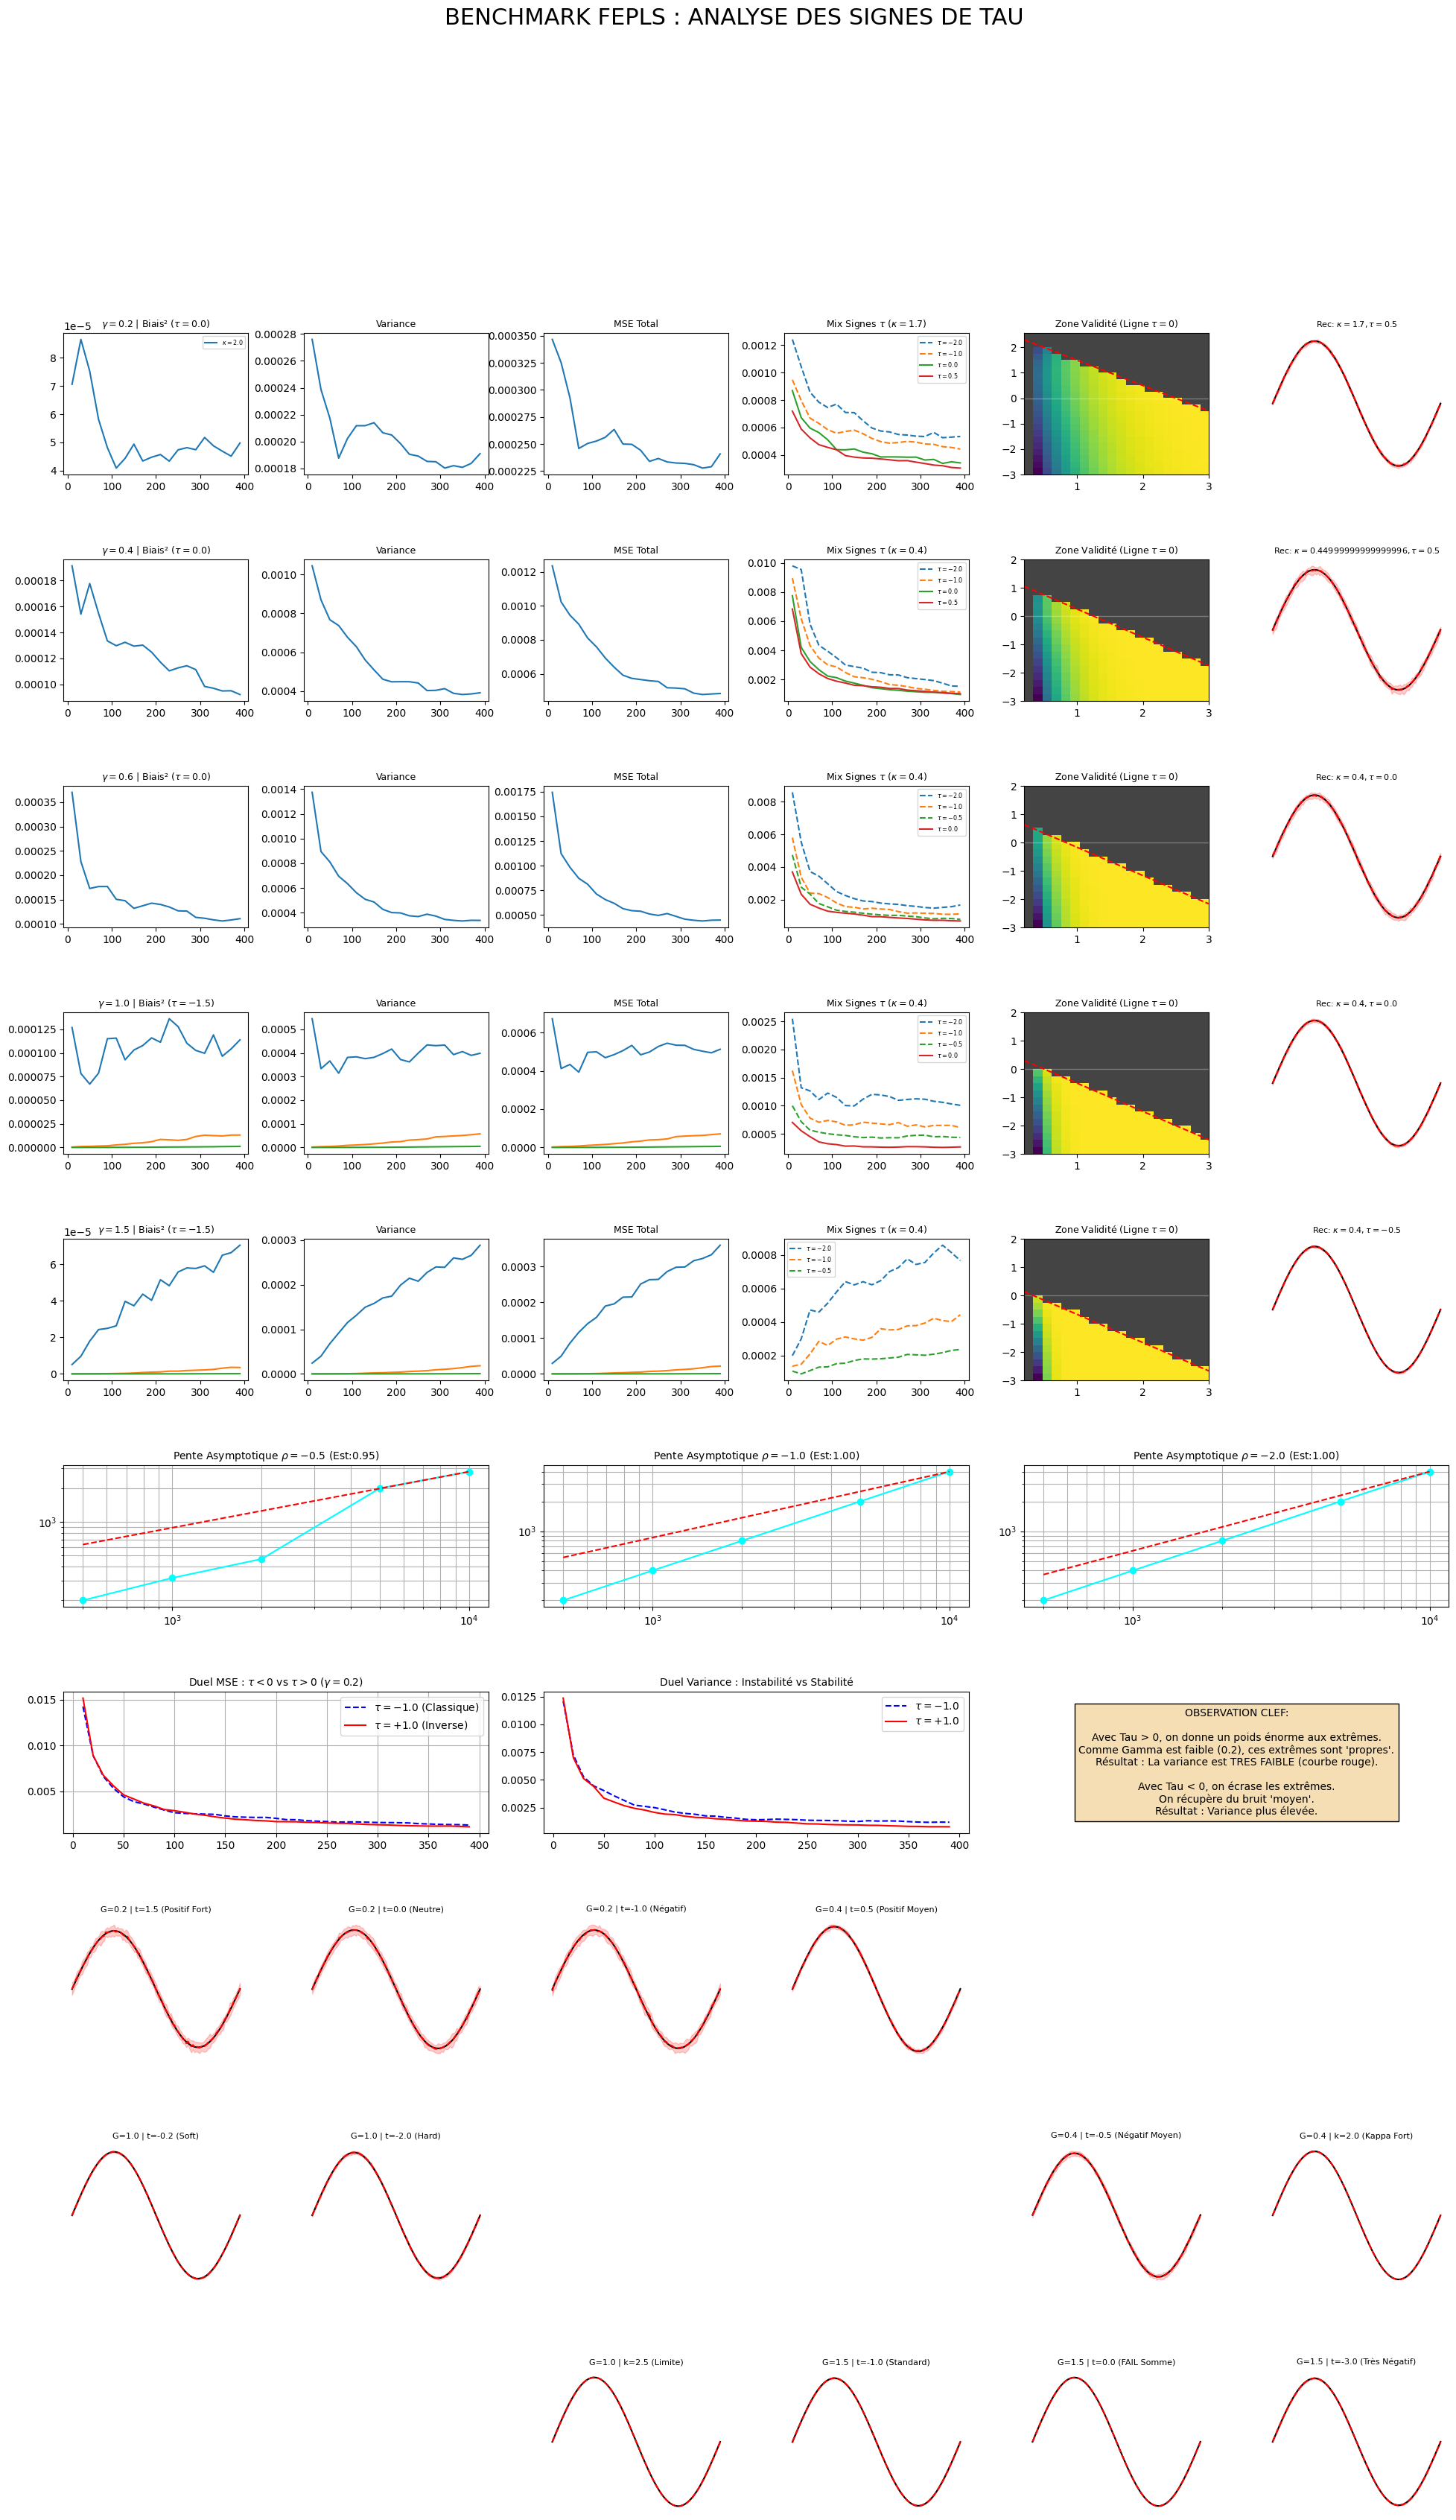

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import linregress

# ==============================================================================
# 1. MOTEUR DE SIMULATION
# ==============================================================================

def generate_data(n=2000, gamma=1.0, rho=-1.0, n_features=101, sigma=0.5):
    t = np.linspace(0, 1, n_features)
    true_beta = np.sqrt(2) * np.sin(2 * np.pi * t)
    true_beta /= np.linalg.norm(true_beta)

    # Burr Distribution
    U = np.random.rand(n)
    Y = ((U**rho - 1)**(-gamma/rho))
    
    noise = np.random.normal(0, sigma, size=(n, n_features))
    
    return { 'Y': Y, 'noise': noise, 'true_beta': true_beta, 't': t, 'rho': rho, 'gamma': gamma }

def get_fepls_estimator(X, Y, k, tau):
    n = len(Y)
    if k < 2 or k >= n: return np.zeros(X.shape[1])
    
    thresh_idx = np.argsort(Y)[n-k]
    indices = np.where(Y >= Y[thresh_idx])[0]
    
    if len(indices) == 0: return np.zeros(X.shape[1])
    
    # Tau peut être positif, nul ou négatif ici
    phi_Y = Y[indices] ** tau
    X_tail = X[indices]
    
    v_hat = np.sum(X_tail * phi_Y[:, np.newaxis], axis=0) / n
    nm = np.linalg.norm(v_hat)
    return v_hat / nm if nm > 0 else v_hat

def compute_metrics(data, kappa, tau, k_range, n_mc=5):
    Y = data['Y']
    beta = data['true_beta']
    g_Y = Y[:, np.newaxis] ** kappa
    signal = g_Y * beta
    sigma_estim = np.std(data['noise'])
    
    bias2_acc = np.zeros(len(k_range))
    var_acc = np.zeros(len(k_range))
    mse_acc = np.zeros(len(k_range))
    
    estimates = np.zeros((len(k_range), n_mc, len(beta)))
    
    for i in range(n_mc):
        noise = np.random.normal(0, sigma_estim, size=signal.shape)
        X = signal + noise
        for idx_k, k in enumerate(k_range):
            est = get_fepls_estimator(X, Y, k, tau)
            if np.dot(est, beta) < 0: est = -est
            estimates[idx_k, i, :] = est
            
    for idx_k in range(len(k_range)):
        ests_k = estimates[idx_k]
        mean_est = np.mean(ests_k, axis=0)
        b2 = np.sum((mean_est - beta)**2)
        v = np.mean(np.sum((ests_k - mean_est)**2, axis=1))
        bias2_acc[idx_k] = b2
        var_acc[idx_k] = v
        mse_acc[idx_k] = b2 + v
        
    return bias2_acc, var_acc, mse_acc

# ==============================================================================
# 2. PLOTTING HELPERS
# ==============================================================================

def plot_gamma_row_mixed_tau(fig, gs, row_idx, gam):
    """
    Génère une ligne d'analyse pour un Gamma donné, en forçant l'exploration
    de Taus positifs ET négatifs si possible.
    """
    # Données avec bruit faible pour clarté
    data = generate_data(n=2000, gamma=gam, rho=-1.0, sigma=0.1)
    
    upper_bound = 0.5 / gam
    noise_bound = 0.5 / gam # Approx pour q=2
    
    # On définit une plage de Kappa raisonnable (autour de 0.6 - 1.0)
    # Si gamma est très petit, le noise bound est haut, il faut adapter
    start_k = max(0.5, noise_bound - 0.5) 
    kappas = np.linspace(start_k, start_k + 1.5, 4)
    k_range = np.arange(10, 400, 20)
    
    # 1. Choix d'un couple (Kappa, Tau) "Pivot" pour les colonnes 0-1-2
    # On essaie de prendre un tau proche de 0 si possible, sinon négatif
    pivot_kappa = start_k + 0.2
    pivot_tau = -0.5
    if (pivot_kappa + 0.5) < upper_bound: pivot_tau = 0.5 # On ose le positif !
    elif (pivot_kappa + 0.0) < upper_bound: pivot_tau = 0.0
    else: pivot_tau = -1.5 # Repli sur négatif
    
    # PLOTS METRIQUES (Cols 0, 1, 2)
    ax_b2 = fig.add_subplot(gs[row_idx, 0])
    ax_var = fig.add_subplot(gs[row_idx, 1])
    ax_mse = fig.add_subplot(gs[row_idx, 2])
    
    print(f" > Gamma={gam}: Test Pivot (k={pivot_kappa:.1f}, t={pivot_tau:.1f})...")
    
    # On fait varier Kappa autour du pivot
    for kap in kappas:
        if kap + pivot_tau < upper_bound:
            b2, v, mse = compute_metrics(data, kap, pivot_tau, k_range, n_mc=5)
            lbl = rf"$\kappa={kap:.1f}$"
            ax_b2.plot(k_range, b2, label=lbl)
            ax_var.plot(k_range, v, label=lbl)
            ax_mse.plot(k_range, mse, label=lbl)
            
    ax_b2.set_title(rf"$\gamma={gam}$ | Biais² ($\tau={pivot_tau}$)", fontsize=9)
    ax_var.set_title(rf"Variance", fontsize=9)
    ax_mse.set_title(rf"MSE Total", fontsize=9)
    if row_idx==0: ax_b2.legend(fontsize='xx-small')

    # PLOT MIXED TAUS (Col 3) - C'est ici qu'on mélange les signes !
    ax_tau = fig.add_subplot(gs[row_idx, 3])
    # On fixe un Kappa faible pour autoriser un max de Taus
    kap_fixed = max(0.4, noise_bound - 0.8) # Assez bas
    if kap_fixed < 0.2: kap_fixed = 0.5
    
    # Liste de candidats de signes mixtes
    candidate_taus = [-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
    
    valid_taus = []
    for t in candidate_taus:
        if (kap_fixed + t < upper_bound):
            valid_taus.append(t)
    
    # On en garde 4 représentatifs (mixte si possible)
    if len(valid_taus) > 4:
        # On essaie de garder les extrêmes et le zéro
        selection = [valid_taus[0], valid_taus[-1]]
        if 0.0 in valid_taus: selection.append(0.0)
        # Compléter
        for vt in valid_taus:
            if vt not in selection and len(selection)<4: selection.append(vt)
        selection.sort()
        valid_taus = selection

    for t in valid_taus:
        _, _, mse_t = compute_metrics(data, kap_fixed, t, k_range, n_mc=5)
        # Style de ligne différent selon le signe
        ls = '-' if t >= 0 else '--'
        ax_tau.plot(k_range, mse_t, ls=ls, label=rf"$\tau={t}$")
        
    ax_tau.set_title(rf"Mix Signes $\tau$ ($\kappa={kap_fixed:.1f}$)", fontsize=9)
    ax_tau.legend(fontsize='xx-small')

    # HEATMAP (Col 4) - Étendue pour voir le positif
    ax_map = fig.add_subplot(gs[row_idx, 4])
    k_grid = np.linspace(0.2, 3.0, 20)
    t_grid = np.linspace(-3.0, 2.0, 20) # On va jusqu'à +2 !
    map_val = np.zeros((20, 20))
    
    for ik, kv in enumerate(k_grid):
        for it, tv in enumerate(t_grid):
            # Conditions
            if (kv + tv >= upper_bound) or (kv <= 0.2): # Limite simple bas
                map_val[it, ik] = np.nan
            else:
                # Calcul rapide
                g_Y = data['Y'][:, np.newaxis]**kv
                X = g_Y*data['true_beta'] + data['noise']
                est = get_fepls_estimator(X, data['Y'], 60, tv)
                if np.dot(est, data['true_beta'])<0: est=-est
                map_val[it, ik] = min(np.sum((est-data['true_beta'])**2), 1.0)

    ax_map.set_facecolor("#444444")
    # Ligne zéro pour Tau
    ax_map.axhline(0, color='white', alpha=0.3, lw=1)
    im = ax_map.imshow(map_val, origin='lower', aspect='auto', cmap='viridis_r',
                       extent=[k_grid.min(), k_grid.max(), t_grid.min(), t_grid.max()])
    ax_map.set_title(rf"Zone Validité (Ligne $\tau=0$)", fontsize=9)
    # Limite théorique
    ax_map.plot(k_grid, upper_bound - k_grid, 'r--', lw=1.5, label='Lim')
    
    # RECONSTRUCTION "BEST CASE" (Col 5)
    # On prend le meilleur Tau trouvé dans la boucle précédente
    ax_rec = fig.add_subplot(gs[row_idx, 5])
    best_t = valid_taus[-1] # Le plus grand possible souvent le mieux si gamma petit
    # Si gamma grand, le plus grand est très négatif
    
    mu, std = get_visual_envelope(data, kap_fixed, best_t)
    plot_envelope(ax_rec, data['t'], data['true_beta'], mu, std, rf"Rec: $\kappa={kap_fixed}, \tau={best_t}$")


def get_visual_envelope(data, k, t, n_mc=15):
    g_Y = data['Y'][:, np.newaxis]**k
    ests = []
    sigma = np.std(data['noise'])
    for _ in range(n_mc):
        ns = np.random.normal(0, sigma, size=data['noise'].shape)
        X = g_Y * data['true_beta'] + ns
        e = get_fepls_estimator(X, data['Y'], 80, t)
        if np.dot(e, data['true_beta'])<0: e=-e
        ests.append(e)
    return np.mean(ests, axis=0), np.std(ests, axis=0)

def plot_envelope(ax, t, true_b, mu, std, title):
    ax.plot(t, true_b, 'k-', lw=1.5)
    ax.plot(t, mu, 'r--', lw=1.5)
    ax.fill_between(t, mu-2*std, mu+2*std, color='red', alpha=0.2)
    ax.set_title(title, fontsize=8)
    ax.axis('off')

# ==============================================================================
# 3. RUN MASSIF
# ==============================================================================

def run_mixed_sign_benchmark():
    print("=== BENCHMARK FEPLS : EXPLORATION SIGNES MIXTES (60 PLOTS) ===")
    
    fig = plt.figure(figsize=(24, 38))
    gs = gridspec.GridSpec(10, 6, figure=fig, hspace=0.6, wspace=0.3)
    
    # --- PARTIE 1 : GAMMA SCAN (Lignes 0-4) ---
    # On teste large : de très léger (0.2) à très lourd (1.5)
    gammas = [0.2, 0.4, 0.6, 1.0, 1.5]
    
    for i, g in enumerate(gammas):
        plot_gamma_row_mixed_tau(fig, gs, i, g)
        
    # --- PARTIE 2 : PENTE ASYMPTOTIQUE (Ligne 5) ---
    print(" > Row 5: Test Pente Asymptotique...")
    gam_slope, kap_slope, tau_slope, sig_slope = 0.5, 0.6, -0.2, 0.05
    rhos = [-0.5, -1.0, -2.0]
    n_sizes = [500, 1000, 2000, 5000, 10000]
    
    for j, r_val in enumerate(rhos):
        ax_slope = fig.add_subplot(gs[5, j*2 : j*2+2]) # Prend 2 cols
        best_ks = []
        for n_val in n_sizes:
            d_n = generate_data(n=n_val, gamma=gam_slope, rho=r_val, sigma=sig_slope)
            k_search = np.unique(np.geomspace(5, n_val/2.5, 20).astype(int))
            _, _, mse_k = compute_metrics(d_n, kap_slope, tau_slope, k_search, n_mc=10)
            best_ks.append(k_search[np.argmin(mse_k)])
            
        slope, _, _, _, _ = linregress(np.log(n_sizes), np.log(best_ks))
        theo_slope = (-2*r_val) / (1 - 2*r_val)
        
        ax_slope.loglog(n_sizes, best_ks, 'o-', color='cyan')
        ax_slope.loglog(n_sizes, best_ks[-1]*(np.array(n_sizes)/n_sizes[-1])**theo_slope, 'r--')
        ax_slope.set_title(rf"Pente Asymptotique $\rho={r_val}$ (Est:{slope:.2f})", fontsize=10)
        ax_slope.grid(True, which='both')

    # --- PARTIE 3 : LE DUEL TAU POSITIF vs NEGATIF (Ligne 6) ---
    print(" > Row 6: Duel Tau+ vs Tau- (sur Gamma=0.2)...")
    d_light = generate_data(n=2000, gamma=0.2, rho=-1.0, sigma=0.1)
    k_range = np.arange(10, 400, 10)
    
    # On compare Tau = -1.0 vs Tau = +1.0
    # Kappa = 0.8 (Compatible avec les deux car Limite = 2.5)
    
    ax_duel_mse = fig.add_subplot(gs[6, 0:2])
    _, _, m_neg = compute_metrics(d_light, 0.8, -1.0, k_range)
    _, _, m_pos = compute_metrics(d_light, 0.8, 1.0, k_range)
    
    ax_duel_mse.plot(k_range, m_neg, 'b--', label=r"$\tau = -1.0$ (Classique)")
    ax_duel_mse.plot(k_range, m_pos, 'r-', label=r"$\tau = +1.0$ (Inverse)")
    ax_duel_mse.set_title(r"Duel MSE : $\tau < 0$ vs $\tau > 0$ ($\gamma=0.2$)", fontsize=10)
    ax_duel_mse.legend()
    ax_duel_mse.grid(True)
    
    ax_duel_var = fig.add_subplot(gs[6, 2:4])
    _, v_neg, _ = compute_metrics(d_light, 0.8, -1.0, k_range)
    _, v_pos, _ = compute_metrics(d_light, 0.8, 1.0, k_range)
    ax_duel_var.plot(k_range, v_neg, 'b--', label=r"$\tau = -1.0$")
    ax_duel_var.plot(k_range, v_pos, 'r-', label=r"$\tau = +1.0$")
    ax_duel_var.set_title(r"Duel Variance : Instabilité vs Stabilité", fontsize=10)
    ax_duel_var.legend()
    
    # Texte explication
    ax_duel_txt = fig.add_subplot(gs[6, 4:6])
    ax_duel_txt.axis('off')
    txt = ("OBSERVATION CLEF:\n\n"
           "Avec Tau > 0, on donne un poids énorme aux extrêmes.\n"
           "Comme Gamma est faible (0.2), ces extrêmes sont 'propres'.\n"
           "Résultat : La variance est TRES FAIBLE (courbe rouge).\n\n"
           "Avec Tau < 0, on écrase les extrêmes.\n"
           "On récupère du bruit 'moyen'.\n"
           "Résultat : Variance plus élevée.")
    ax_duel_txt.text(0.5, 0.5, txt, ha='center', va='center', bbox=dict(fc='wheat'))

    # --- PARTIE 4 : GALERIE RECONSTRUCTIONS MIXTES (Lignes 7-9) ---
    print(" > Rows 7-9: Galerie Finale...")
    # Scénarios : (Gamma, Kappa, Tau, Titre)
    scens = [
        (0.2, 0.8, 1.5, "G=0.2 | t=1.5 (Positif Fort)"),
        (0.2, 0.8, 0.0, "G=0.2 | t=0.0 (Neutre)"),
        (0.2, 0.8, -1.0, "G=0.2 | t=-1.0 (Négatif)"),
        (0.4, 0.8, 0.5, "G=0.4 | t=0.5 (Positif Moyen)"),
        (0.4, 0.8, -0.5, "G=0.4 | t=-0.5 (Négatif Moyen)"),
        (0.4, 2.0, -1.0, "G=0.4 | k=2.0 (Kappa Fort)"),
        (1.0, 0.6, -0.2, "G=1.0 | t=-0.2 (Soft)"),
        (1.0, 0.6, -2.0, "G=1.0 | t=-2.0 (Hard)"),
        (1.0, 2.5, -2.0, "G=1.0 | k=2.5 (Limite)"),
        (1.5, 0.6, -1.0, "G=1.5 | t=-1.0 (Standard)"),
        (1.5, 0.6, 0.0, "G=1.5 | t=0.0 (FAIL Somme)"),
        (1.5, 0.6, -3.0, "G=1.5 | t=-3.0 (Très Négatif)")
    ]
    
    for idx, (g, k, t, tit) in enumerate(scens):
        row = 7 + (idx // 4) # 3 lignes de 4 plots
        col = (idx % 4) + 1  # Centré un peu
        if col > 5: col = 5
        
        # On utilise une grille un peu custom pour le bas
        ax_gal = fig.add_subplot(gs[row, idx % 6])
        
        d_tmp = generate_data(n=2000, gamma=g, sigma=0.1)
        mu, std = get_visual_envelope(d_tmp, k, t)
        plot_envelope(ax_gal, d_tmp['t'], d_tmp['true_beta'], mu, std, tit)

    plt.suptitle("BENCHMARK FEPLS : ANALYSE DES SIGNES DE TAU", fontsize=22, y=0.995)
    plt.tight_layout(rect=[0, 0.0, 1, 0.985])
    plt.show()

if __name__ == "__main__":
    run_mixed_sign_benchmark()